# PLS model for the mPro of CoV2

## Function

CA atoms of the residues : 47, 167, 190, 25, 143 form a surface that roughly covers the substrate binding area of the mPro.

I calculate the maximum area of the pentagon formed from these points using triangles that create that surface.

This area is used as a function to estimate the "openness" of the substrate binding site and serves as the training for the PLS model.



In [1]:
# imports

import numpy as np
import MDAnalysis as md
import pylab as plt
import seaborn as sns
import scipy as scp
import os 
from sklearn import mixture
import pandas as pd
import wget
import time
import pickle
from sklearn import cross_decomposition
from scipy import linalg
import matplotlib as mpl
from matplotlib.colors import LogNorm

In [2]:
# constants

colors = ['r','g','b','y','cyan','purple','gray']
#states = ['monomer','monomer_sub','dimerA','dimerB','dimer2A','dimer2B','dimer_sub2A','dimer_sub2B',\
          #'dimer_quad_mutantA','dimer_quad_mutantB']

default_figsize = (5,5)
state_names = {'monomer':'apo-Monomer','monomer_sub':"bound-Monomer",'dimer_sub1AA':\
               'singly-bound (B) Dimer-chain A',\
               'dimer_sub1AB':'singly-bound (B) Dimer-chain B',\
               'dimer_sub1BA':'singly-bound (A) Dimer-chain A',\
               'dimer_sub1BB':'singly-bound (A) Dimer-chain B','dimer_sub2A':'doubly-bound dimer-chain A',\
               'dimer_sub2B':'doubly-bound dimer-chain B','dimerA':'apo-Dimer-chain A',\
               'dimerB':'apo-Dimer-chain B','dimer_quad_mutantA':'double mutant-chain A',\
               'dimer_quad_mutantB':'double mutant-chain B'}
n_states = len(state_names)
data_path = '/wrk/kaptan/projects/covid/data/'
pls_path = '/wrk/kaptan/projects/covid/analysis/pls/'

n_runs = 10

In [17]:
# functions

#area of polygon poly
def poly_area(points):
    if len(points) < 3: # not a plane - no area
        return 0
    total = [0, 0, 0]
    N = len(points)
    for i in range(N):
        vi1 = points[i]
        vi2 = points[(i+1) % N]
        prod = np.cross(vi1, vi2)
        total[0] += prod[0]
        total[1] += prod[1]
        total[2] += prod[2]
    result = np.dot(total, unit_normal(points[0], points[1], points[2]))
    return abs(result/2)

#unit normal vector of plane defined by points a, b, and c
def unit_normal(a, b, c):
    x = np.linalg.det([[1,a[1],a[2]],
             [1,b[1],b[2]],
             [1,c[1],c[2]]])
    y = np.linalg.det([[a[0],1,a[2]],
             [b[0],1,b[2]],
             [c[0],1,c[2]]])
    z = np.linalg.det([[a[0],a[1],1],
             [b[0],b[1],1],
             [c[0],c[1],1]])
    magnitude = (x**2 + y**2 + z**2)**.5
    return (x/magnitude, y/magnitude, z/magnitude)\

def tpangle(m):
    
    ba = m[1,:] - m[0,:]
    bc = m[1,:] - m[2,:]
    #print(m[1,:])
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)
    
# save data
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
    
# plot GMM results

def plot_results(X, Y_, means, covariances, index,labels=[],xlim=[],ylim=[],colors = []):
    fig = plt.figure(figsize=(20,20))
    splot = plt.subplot(2, 1, 1 + index,)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, colors)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], s =1, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.8)
        splot.add_artist(ell)
        #means = means[means_[:,0].argsort()]
    plt.scatter(means[:,0],means[:,1],c=colors[:len(means)],s=200,edgecolor = 'white')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.xticks([2,4,6,8,10])
    plt.yticks([7,9,11])  

## data structures

    State:      Monomer Monomer-sub DimerAB Dimer-subAB

    Sims:       100     10          10      5

    Properties: Area dSidechain dCA




# Pandas get PDBs

In [4]:
# get PDBs with bound structure

pdbs = pd.read_csv('/wrk/kaptan/projects/covid/SARS-Cov-2-main-protease-LOI.tsv', sep='\t',header=0)

pdbs.columns = ['ID','Release Date', 'LOI ID', 'LOI Molecular Weight', 'LOI InCHI Key']

pdb_path = '/wrk/kaptan/projects/covid/PDBs/mPro/'
base_url = 'https://files.rcsb.org/download/'

for pdbID in pdbs['ID']:
    change_name = pdbID + ".pdb"
    cur_url = base_url + pdbID + ".pdb1"
    if not os.path.exists(pdb_path + change_name):
        wget.download(cur_url, out=pdb_path)
        os.rename(pdb_path + pdbID.lower() + ".pdb1", os.path.join(pdb_path + change_name))

In [5]:
# all PDBs for mPro from RSCB

all_pdbs = np.genfromtxt('all_pdbs.csv',dtype='str',delimiter=',',autostrip=True)
pdb_path = '/wrk/kaptan/projects/covid/PDBs/mPro/'
base_url = 'https://files.rcsb.org/download/'

for pdbID in all_pdbs:
    change_name = pdbID + ".pdb"
    down_name = pdbID + ".pdb"
    cur_url = base_url + pdbID + ".pdb1"
    #print(cur_url)
    if not os.path.exists(pdb_path + change_name):
        wget.download(cur_url, out=pdb_path)
        os.rename(pdb_path + pdbID.lower() + ".pdb1", os.path.join(pdb_path + change_name))

In [7]:
# generate data
data = {}

quad_pdb = 'common'
non_quad_pdb = 'prot'



chainB = "/wrk/kaptan/projects/covid/data/monomer/chainB.pdb"
for state in state_names.keys():
    # dimer or monomer
    print(state)
    
    #if 'quad' not in state: continue
    
    data[state] ={}
    print("Currently on state: ",state)
    if state[:5] != 'dimer':
        data_path = '/wrk/kaptan/projects/covid/data/' + state + '/'
    else:
        data_path = '/wrk/kaptan/projects/covid/data/' + state[:-1] + '/'
    print(data_path)
    
    
    # runs
    for run in range(0,n_runs):
        if 'quad' in state:
            pdb = "/wrk/kaptan/projects/covid/data/monomer/" + quad_pdb + ".pdb"
            part_xtc = data_path + quad_pdb
        else:
            pdb = "/wrk/kaptan/projects/covid/data/monomer/" + non_quad_pdb + ".pdb"
            part_xtc = data_path + non_quad_pdb
            
        
        if state[:5] != 'dimer':
            xtc =  part_xtc +str(run) + ".xtc"
        else:
             xtc =part_xtc +state[-1] +str(run) + ".xtc"
        
        if not os.path.exists(xtc):
            print(xtc)
            print("This trajectory is not simulated yet.")
            continue
                
        model = md.Universe(pdb,xtc)
        modelB = md.Universe(chainB)
        
        n_frames = model.trajectory.n_frames
        n_atoms = model.atoms.n_atoms
        print("Currently on trajectory: " + str(run) + " with frames: ",n_frames)
        r42G = model.select_atoms("resid 42 and name CE1")
        r146G = model.select_atoms("resid 146 and name SG")

        r42C = model.select_atoms("resid 42 and name CA")
        r146C = model.select_atoms("resid 146 and name CA")

        points = model.select_atoms("resid 190 143 50 25 167 and name CA")
        three_points = model.select_atoms("resid 94 128 279 and name CA")
        
        if 'quad' in state:
            print("I am here")
            r291B = modelB.select_atoms("resid 289 and name CA")
            r5B = modelB.select_atoms("resid 3 and name CA")
        
            r291A = model.select_atoms("resid 289 and name CA")
            r5A = model.select_atoms("resid 3 and name CA")
            
        else:
            r291B = modelB.select_atoms("resid 291 and name CD")
            r5B = modelB.select_atoms("resid 5 and name CZ")
        
            r291A = model.select_atoms("resid 291 and name CD")
            r5A = model.select_atoms("resid 5 and name CZ")
        
        # start extracting data
        #start = 9000
        start = 4000
        end = n_frames
        
        if n_frames<start: 
            print("This trajectory has insufficient data.")
            continue

        data[state][run] = {}
        
        data[state][run]['area'] = np.zeros(end-start)
        data[state][run]['dside'] = np.zeros(end-start)
        data[state][run]['dCA'] = np.zeros(end-start)
        data[state][run]['angle'] = np.zeros(end-start)
        data[state][run]['dinter1'] = np.zeros(end-start)
        data[state][run]['dinter2'] = np.zeros(end-start)

        counter_fr = 0

        for frame in model.trajectory:
            print("Currently on frame : ",counter_fr,end='\r')
            if counter_fr<start:
                counter_fr+=1
                continue
            if counter_fr==end:
                break

            data[state][run]['dside'][counter_fr-start] = scp.spatial.distance.euclidean\
            (r42G.positions,r146G.positions)
            data[state][run]['dCA'][counter_fr-start] = scp.spatial.distance.euclidean\
            (r42C.positions,r146C.positions)
            data[state][run]['area'][counter_fr-start] = poly_area(points.positions)
            data[state][run]['angle'][counter_fr-start] = tpangle(three_points.positions)
            
            data[state][run]['dinter1'][counter_fr-start] = scp.spatial.distance.euclidean\
            (r5A.positions,r291B.positions)
            
            data[state][run]['dinter2'][counter_fr-start] = scp.spatial.distance.euclidean\
            (r291A.positions,r5B.positions)
        

            counter_fr+=1
            #break
        #break

monomer
Currently on state:  monomer
/wrk/kaptan/projects/covid/data/monomer/
Currently on trajectory: 0 with frames:  5896
Currently on trajectory: 1 with frames:  14327
Currently on trajectory: 2 with frames:  4838
Currently on trajectory: 3 with frames:  4730
Currently on trajectory: 4 with frames:  4749
Currently on trajectory: 5 with frames:  4821
Currently on trajectory: 6 with frames:  4676
Currently on trajectory: 7 with frames:  4660
Currently on trajectory: 8 with frames:  14580
Currently on trajectory: 9 with frames:  4636
monomer_subn frame :  4635
Currently on state:  monomer_sub
/wrk/kaptan/projects/covid/data/monomer_sub/
Currently on trajectory: 0 with frames:  5175
Currently on trajectory: 1 with frames:  4028
Currently on trajectory: 2 with frames:  9736
Currently on trajectory: 3 with frames:  9756
Currently on trajectory: 4 with frames:  9645
Currently on trajectory: 5 with frames:  9690
Currently on trajectory: 6 with frames:  9739
Currently on trajectory: 7 with f

In [ ]:
# save data

save_obj(data,'data_area_dist')

In [6]:
# load data

data = load_obj('data_area_dist')

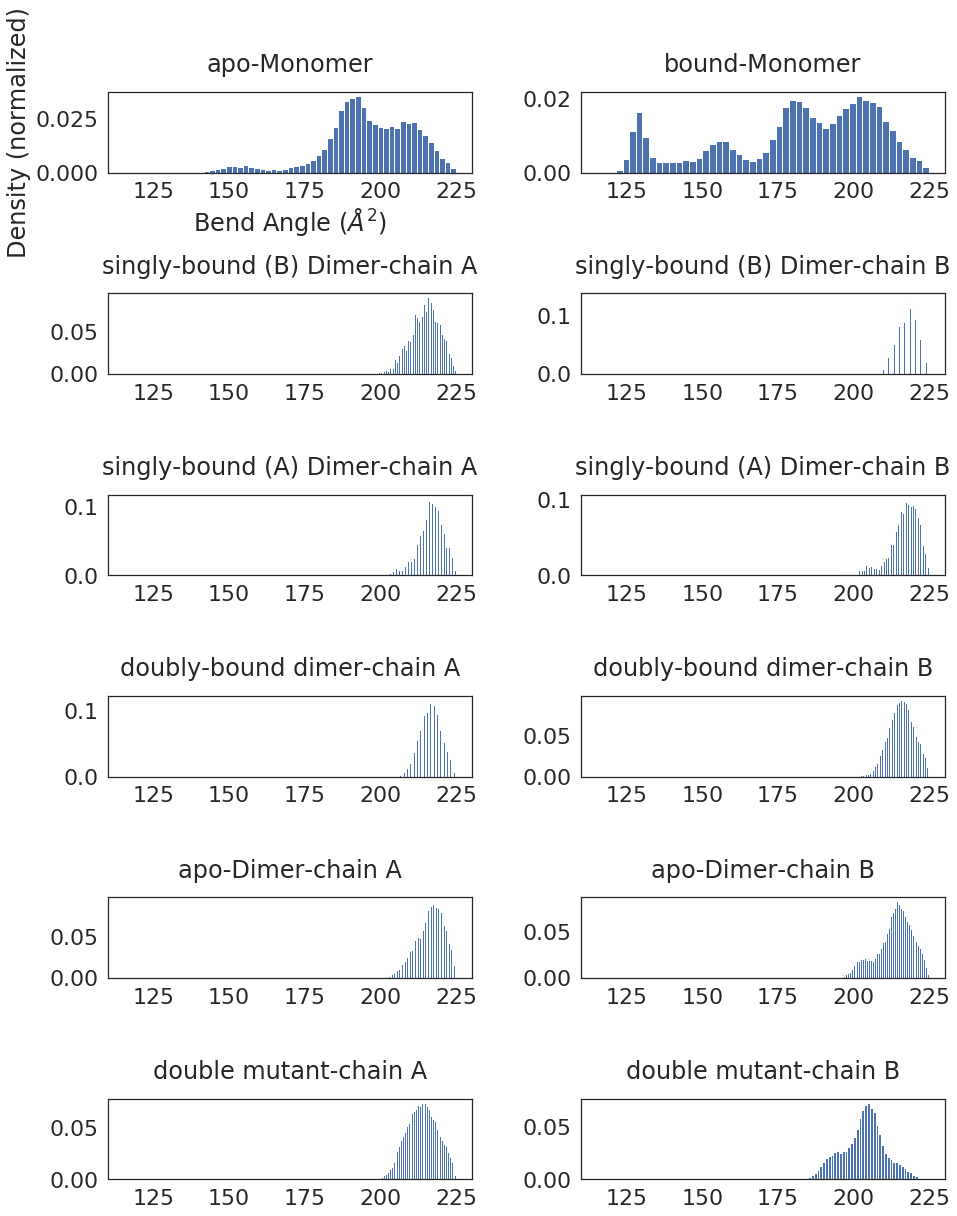

In [79]:
# angle histograms
sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(data.keys())//2,2 ,figsize=(15,20))
fig.subplots_adjust(hspace=1.5,wspace=0.3)
for state in enumerate(data.keys()):
    #print(state[1])
    side_hist = np.array([])
    for run in data[state[1]].keys():
    
        side_hist = np.append(side_hist,data[state[1]][run]['angle']+45)
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    #print(state[0],xind,yind)
    ax[xind][yind].hist(np.array(side_hist),density = True,bins=np.linspace(min(side_hist),max(side_hist),50))
    ax[xind][yind].set_xlim(110,230)
    #ax[xind][yind].set_ylim(0,0.07)
    ax[xind][yind].set_title(state_names[state[1]],pad=20)
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("Bend Angle ($\AA^2$)")
        ax[xind][yind].set_ylabel("Density (normalized)")

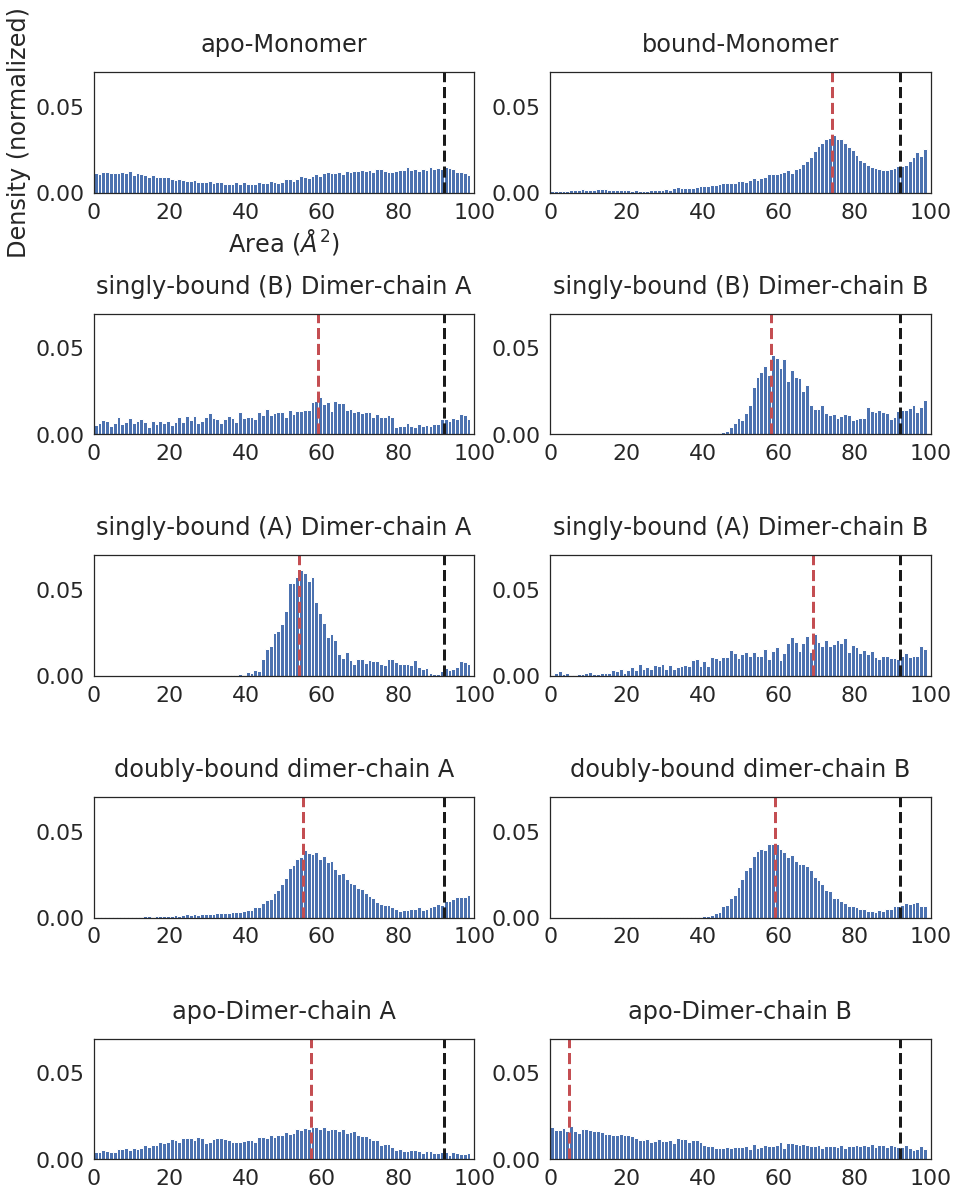

In [80]:
# area histograms
sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(data)//2 -1 ,2 ,figsize=(15,20))
fig.subplots_adjust(hspace=1.,wspace=0.2)
for state in enumerate(data.keys()):
    if 'quad' in state[1]: continue
    #print(state[1])
    side_hist = np.array([])
    for run in data[state[1]].keys():
    
        side_hist = np.append(side_hist,data[state[1]][run]['area'])
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    #print(state[0],xind,yind)
    
    ax[xind][yind].hist(np.array(side_hist),density = True,bins=range(0,100,1))
    
    
    n , edges = np.histogram(np.array(side_hist),density = True,bins=range(0,100,1))
    #print(np.argmax(n))
   
    if state[1] == 'monomer':
        ax[xind][yind].axvline(x=np.argmax(n), color = 'k', linewidth = 3, linestyle = '--')
        mon_mp = np.argmax(n)
    else:
        ax[xind][yind].axvline(x=mon_mp, color = 'k', linewidth = 3, linestyle = '--')
        ax[xind][yind].axvline(x=np.argmax(n), color = 'r', linewidth = 3, linestyle = '--')
      
    
    ax[xind][yind].set_xlim(0,100)
    ax[xind][yind].set_ylim(0,0.07)
    ax[xind][yind].set_title(state_names[state[1]],pad=20)
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("Area ($\AA^2$)")
        ax[xind][yind].set_ylabel("Density (normalized)")

In [ ]:
# dinter1
sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(data),10 ,figsize=(60,30))
fig.subplots_adjust(hspace=1,wspace=0.2)
for state in enumerate(data.keys()):
    #print(state[1])

    for run in data[state[1]].keys():
    
        ax[state[0]][run].plot(data[state[1]][run]['dside'],color='b')
        ax[state[0]][run].plot(data[state[1]][run]['dCA'],color='r')
    
        ax[state[0]][run].set_title(state_names[state[1]] + '\n' + str(run) ,pad=20)
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("dInter1 ($\AA$)")
        ax[xind][yind].set_ylabel("Density (normalized)")

In [ ]:
# dinter1
sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(data)//2,2 ,figsize=(15,20))
fig.subplots_adjust(hspace=1,wspace=0.2)
for state in enumerate(data.keys()):
    #print(state[1])
    side_hist1 = np.array([])
    side_hist2 = np.array([])
    for run in data[state[1]].keys():
    
        side_hist1 = np.append(side_hist1,data[state[1]][run]['dinter1'])
        side_hist2 = np.append(side_hist2,data[state[1]][run]['dinter2'])
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    #print(state[0],xind,yind)
    ax[xind][yind].hist(np.array(side_hist1),density = True,bins=50,color='b',alpha=0.8)
    ax[xind][yind].hist(np.array(side_hist2),density = True,bins=50,color='r',alpha=0.8)
    ax[xind][yind].set_xlim(0,25)#max(max(side_hist1),max(side_hist2)+1))
    ax[xind][yind].set_ylim(0,1)
    ax[xind][yind].set_title(state_names[state[1]],pad=20)
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("dInter1 ($\AA$)")
        ax[xind][yind].set_ylabel("Density (normalized)")

In [ ]:
# dinter3
sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(data)//2,2 ,figsize=(15,20))
fig.subplots_adjust(hspace=1,wspace=0.2)
for state in enumerate(data.keys()):
    #print(state[1])
    side_hist1 = np.array([])
    side_hist2 = np.array([])
    for run in data[state[1]].keys():
    
        side_hist1 = np.append(side_hist1,data[state[1]][run]['dinter3'])
        side_hist2 = np.append(side_hist2,data[state[1]][run]['dinter4'])
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    #print(state[0],xind,yind)
    ax[xind][yind].hist(np.array(side_hist1),density = True,bins=50,color='b',alpha=0.8)
    ax[xind][yind].hist(np.array(side_hist2),density = True,bins=50,color='r',alpha=0.8)
    ax[xind][yind].set_xlim(0,25)#max(max(side_hist1),max(side_hist2)+1))
    ax[xind][yind].set_ylim(0,1)
    ax[xind][yind].set_title(state_names[state[1]],pad=20)
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("dInter1 ($\AA$)")
        ax[xind][yind].set_ylabel("Density (normalized)")

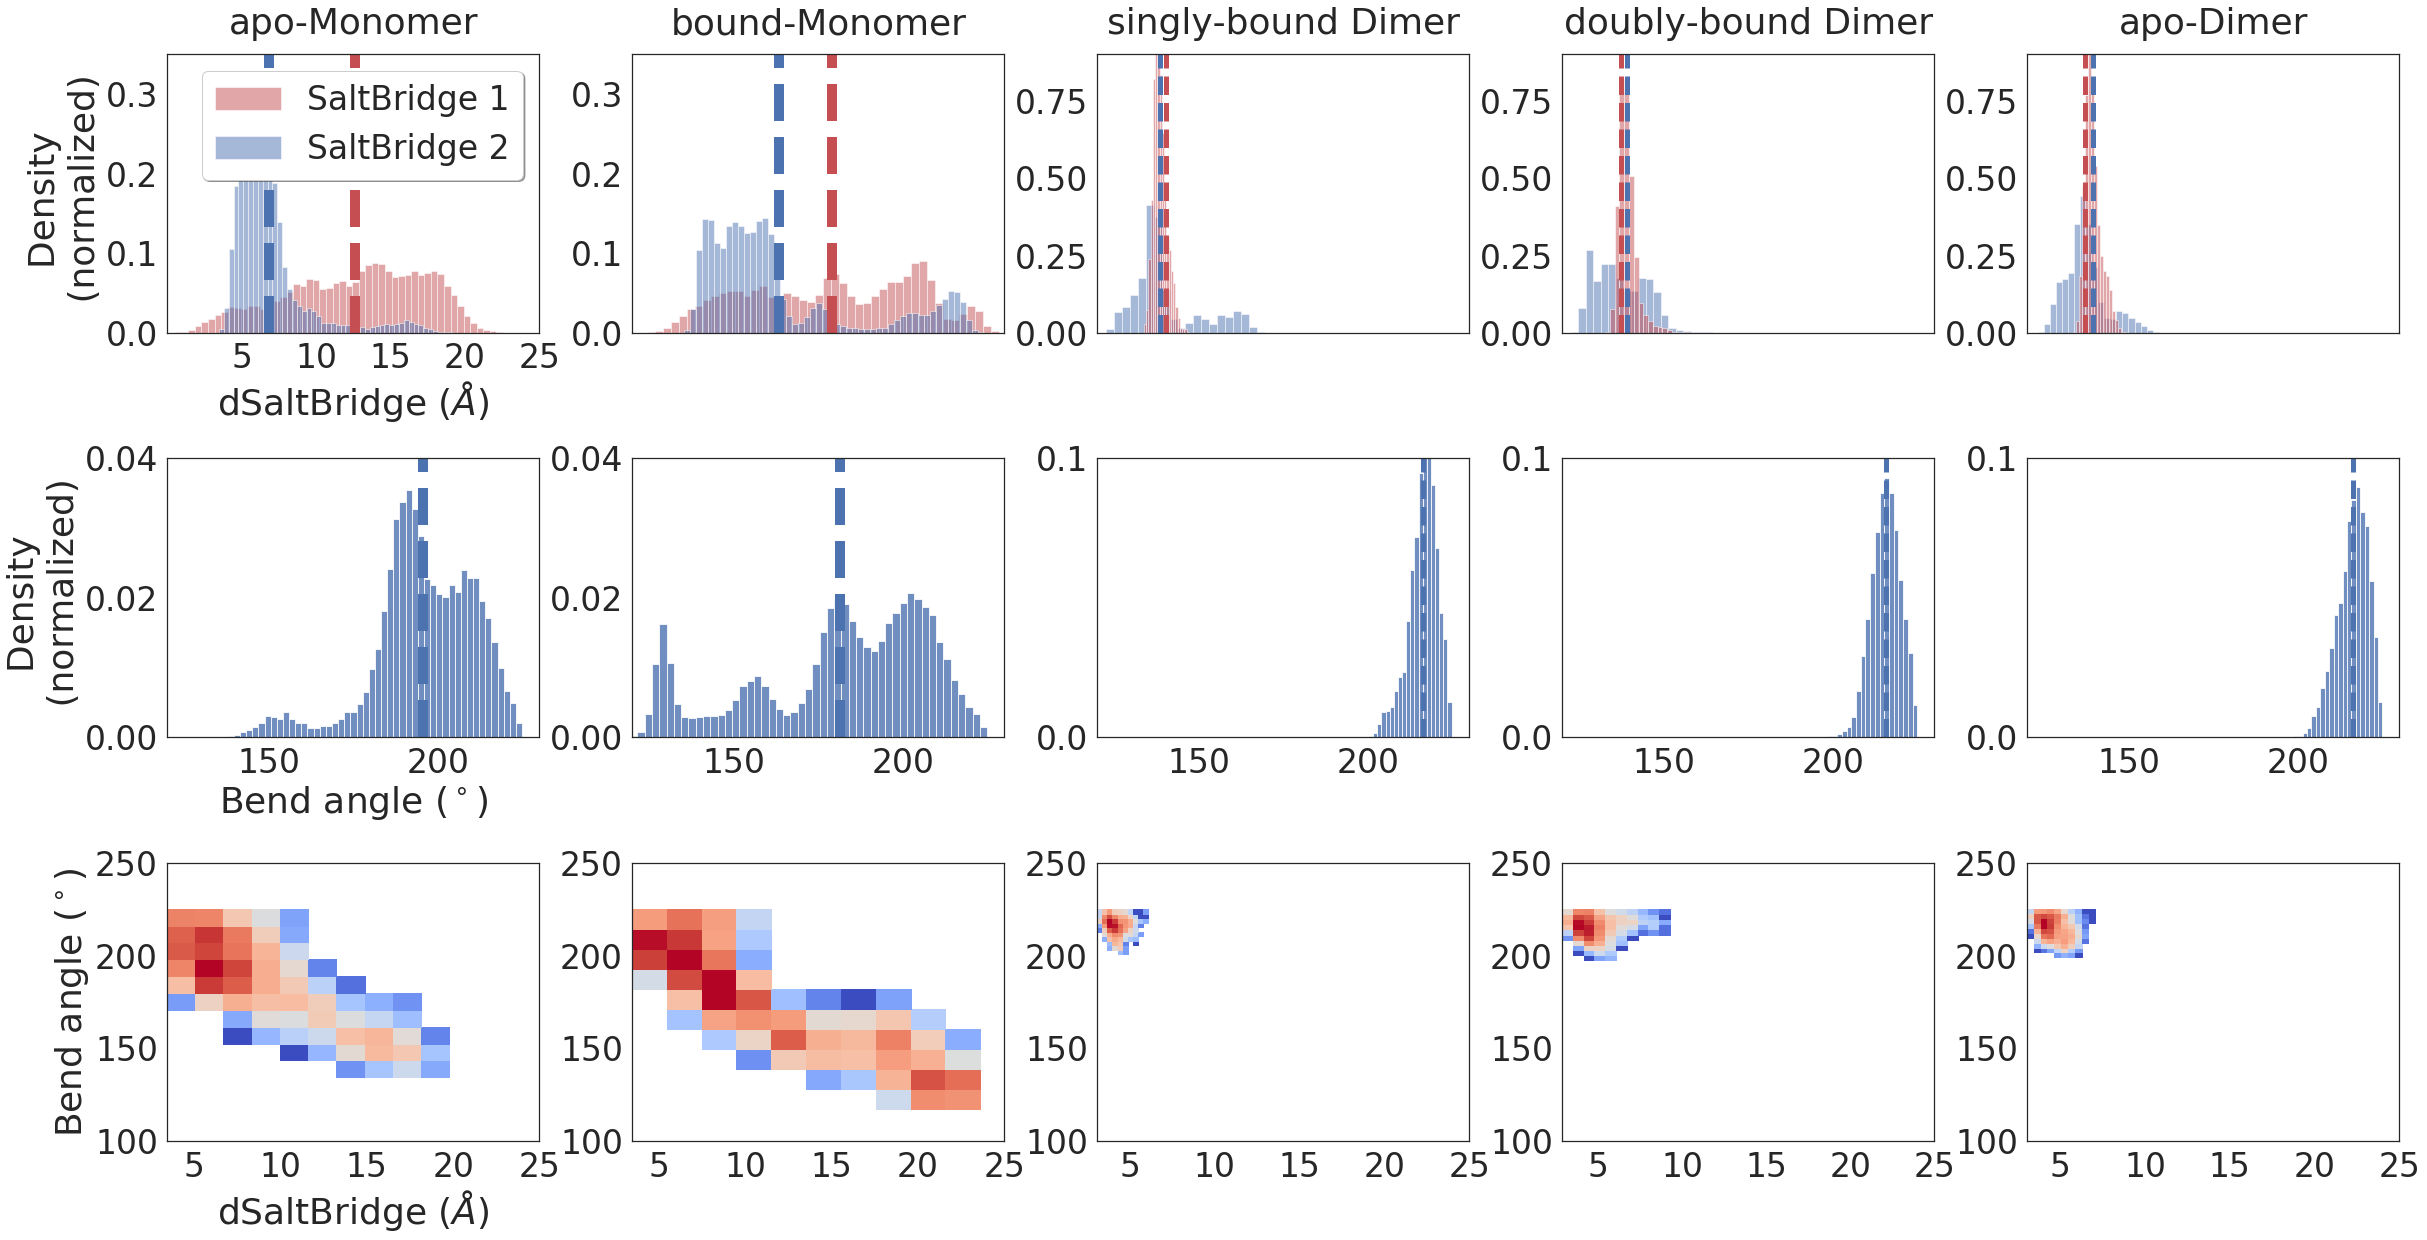

In [11]:
# dinter1
sns.set(font_scale = 3)
sns.set_style('white')

fig,ax = plt.subplots(3,5 ,figsize=(60,20))
fig.subplots_adjust(hspace=0.45,wspace=0.25)
st_count = 0
for state in data.keys(): 

    if state not in ['monomer','monomer_sub','dimerA','dimer_sub1BA','dimer_sub2B']:
        continue
    #print(state)
    side_hist1 = np.array([])
    side_hist2 = np.array([])
    angle = np.array([])
    for run in data[state].keys():
        side_hist1 = np.append(side_hist1,data[state][run]['dinter1'])
        side_hist2 = np.append(side_hist2,data[state][run]['dinter2'])
        angle = np.append(angle,data[state][run]['angle']+45)
    
    if 'sub1' in state:
        ax[0][st_count].set_title('singly-bound Dimer',pad=20)
    elif 'sub2' in state:
        ax[0][st_count].set_title('doubly-bound Dimer',pad=20)
    elif 'dimerA' in state:
        ax[0][st_count].set_title('apo-Dimer',pad=20)
    else:
        ax[0][st_count].set_title(state_names[state],pad=20)
    
    ax[0][st_count].set_xlim(0,25)
    ax[0][st_count].set_ylim(0,0.35)
    
    ax[1][st_count].set_xlim(120,230)
    ax[1][st_count].set_ylim(0,0.035)
     
    if 'monomer' in state:
        
        ax[0][st_count].hist(np.array(side_hist1),density = True,bins=50,color='r',\
                             alpha=0.5,label = 'SaltBridge 1')
        ax[0][st_count].hist(np.array(side_hist2),density = True,bins=50,color='b',\
                             alpha=0.5,label = 'SaltBridge 2')
        ax[1][st_count].hist(np.array(angle),density = True,bins=50,color='b',alpha=0.8)
        
        ax[0][st_count].axvline(x=side_hist1.mean(), color = 'r', linewidth = 10, linestyle = '--')
        ax[0][st_count].axvline(x=side_hist2.mean(), color = 'b', linewidth = 10, linestyle = '--')
        ax[1][st_count].axvline(x=angle.mean(), color = 'b', linewidth = 10, linestyle = '--')
        ax[0][st_count].set_xticks([5,10,15,20,25])
        ax[1][st_count].set_yticks([0,0.02,0.04])
        ax[0][st_count].set_yticks([0,0.1,0.2,0.3])

        
    if 'dimer' in state:
        ax[0][st_count].set_ylim(0,0.9)
        ax[1][st_count].set_ylim(0,0.1)
        ax[0][st_count].hist(np.array(side_hist1),density = True,bins=20,color='b',\
                             alpha=0.5,label = 'SaltBridge 1')
        ax[0][st_count].hist(np.array(side_hist2),density = True,bins=20,color='r',
                             alpha=0.5,label = 'SaltBridge 2')
        ax[1][st_count].hist(np.array(angle),density = True,bins=20,color='b',alpha=0.8)
        ax[0][st_count].axvline(x=side_hist1.mean(), color = 'r', linewidth = 5, linestyle = '--')
        ax[0][st_count].axvline(x=side_hist2.mean(), color = 'b', linewidth =5, linestyle = '--')
        ax[1][st_count].axvline(x=angle.mean(), color = 'b', linewidth = 5, linestyle = '--')
        ax[0][st_count].set_xticks([5,10,15,20,25])
        ax[1][st_count].set_yticks([0, 0.1])
        
    ax[2][st_count].hist2d(side_hist2,angle,density=True, \
                               cmap=plt.cm.coolwarm,norm=LogNorm())
    ax[2][st_count].set_xticks([5,10,15,20,25])
    ax[2][st_count].set_yticks([100,150,200,250])
        
        
    if state == 'monomer':
        ax[0][st_count].set_xlabel("dSaltBridge ($\AA$)")
        ax[1][st_count].set_xlabel("Bend angle ($^\circ$)")
        ax[2][st_count].set_xlabel("dSaltBridge ($\AA$)")
        
        ax[0][st_count].set_ylabel("Density \n (normalized)")
        ax[1][st_count].set_ylabel("Density \n (normalized)")
        ax[2][st_count].set_ylabel("Bend angle ($^\circ$)")

        ax[0][st_count].legend(fancybox=True,shadow=True)
    else:
        ax[0][st_count].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
        
    st_count+=1

In [ ]:
# d-side
sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(state_names)//2,2 ,figsize=(15,20))
fig.subplots_adjust(hspace=1.3,wspace=0.17)
for state in enumerate(data.keys()):
    #print(state[1])
    side_hist = np.array([])
    for run in data[state[1]].keys():
    
        side_hist = np.append(side_hist,data[state[1]][run]['dside'])
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    #print(state[0],xind,yind)
    ax[xind][yind].hist(np.array(side_hist),density = True,bins=50)
    ax[xind][yind].set_xlim(0,10)
    ax[xind][yind].set_ylim(0,1.5)
    ax[xind][yind].set_title(state_names[state[1]],pad=20)
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("dSidechain ($\AA$)")
        ax[xind][yind].set_ylabel("Density (normalized)")

In [ ]:
# dCA histograms
sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(state_names)//2,2 ,figsize=(15,20))
fig.subplots_adjust(hspace=2,wspace=0.5)
for state in enumerate(data.keys()):
    #print(state[1])
    side_hist = np.array([])
    for run in data[state[1]].keys():
    
        side_hist = np.append(side_hist,data[state[1]][run]['dCA'])
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    #print(state[0],xind,yind)
    ax[xind][yind].hist(np.array(side_hist),density = True,bins=30)
    ax[xind][yind].set_xlim(5,15)
    #ax[xind][yind].set_ylim(0,0.05)
    ax[xind][yind].set_title(state_names[state[1]],pad=20)
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("dCA ($\AA$)")
        ax[xind][yind].set_ylabel("Density (normalized)")


In [ ]:
# angle vs dinter1

sns.set(font_scale = 1.5)
sns.set_style('white')
fig,ax = plt.subplots(len(state_names)//2 -1,4,figsize=(20,20))
fig.subplots_adjust(hspace=0.5,wspace=0.4)
for state in enumerate(data.keys()):
    if 'quad' in state[1]:
        continue
    dside = np.array([])
    dCA1 = np.array([])
    dCA2 = np.array([])
    for run in data[state[1]].keys():
        #if run != 4: 
            #continue
        dside = np.append(dside,data[state[1]][run]['angle']+45)
        dCA1 = np.append(dCA1,data[state[1]][run]['dinter1'])
        dCA2 = np.append(dCA2,data[state[1]][run]['dinter2'])
        #break
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    #sns.regplot(x=dside, y=dCA, ax=,size=0.01)
    #ax[xind][yind].scatter(dside,dCA,s=0.5)
    im = ax[xind][yind*2].hist2d(dside,dCA1,bins=(range(100,250,5),range(0,30,2)),density=True, \
                               cmap=plt.cm.coolwarm,norm=LogNorm())
    im = ax[xind][yind*2+1].hist2d(dside,dCA2,bins=(range(100,250,5),range(0,30,2)),density=True, \
                               cmap=plt.cm.coolwarm,norm=LogNorm())
    ax[xind][yind].set_ylim(0,25)
    ax[xind][yind].set_xlim(100,250)
    
    #ax[xind][yind].set_xticks([2,4,6,8,10])
    #ax[xind][yind].set_yticks([6,8,10])
    ax[xind][yind*2].set_title(state_names[state[1]])
    ax[xind][yind*2+1].set_title(state_names[state[1]])
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("Angle ($^\circ$)")
        ax[xind][yind].set_ylabel("dSaltBridge1 ($\AA$)")
        
        ax[xind][yind*2+1].set_xlabel("Angle ($^\circ$)")
        ax[xind][yind*2+1].set_ylabel("dSaltBridge2 ($\AA$)")
      
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

In [ ]:
# CA vs CA dist

sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(2,2,figsize=(15,15))
fig.subplots_adjust(hspace=0.35,wspace=0.2)
for state in enumerate(['dimer','dimer_sub1A','dimer_sub1B','dimer_sub2']):
    dCAA = np.array([])
    dCAB = np.array([])
    for run in data[state[1]+'A'].keys():
        dCAA = np.append(dCAA,data[state[1]+'A'][run]['dinter1'])
        dCAB = np.append(dCAB,data[state[1]+'B'][run]['dinter2'])

        #break
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    ax[xind][yind].scatter(dCAA,dCAB,s=0.5)
    #ax[xind][yind].set_ylim(6,12)
    #ax[xind][yind].set_xlim(2,10)
    #ax[xind][yind].set_xticks([2,4,6,8,10])
    #ax[xind][yind].set_yticks([6,8,10])
    ax[xind][yind].set_title(state[1])
    if state[1] == 'dimer':
        ax[xind][yind].set_xlabel("dCAA ($\AA$)")
        ax[xind][yind].set_ylabel("dCAB ($\AA$)")

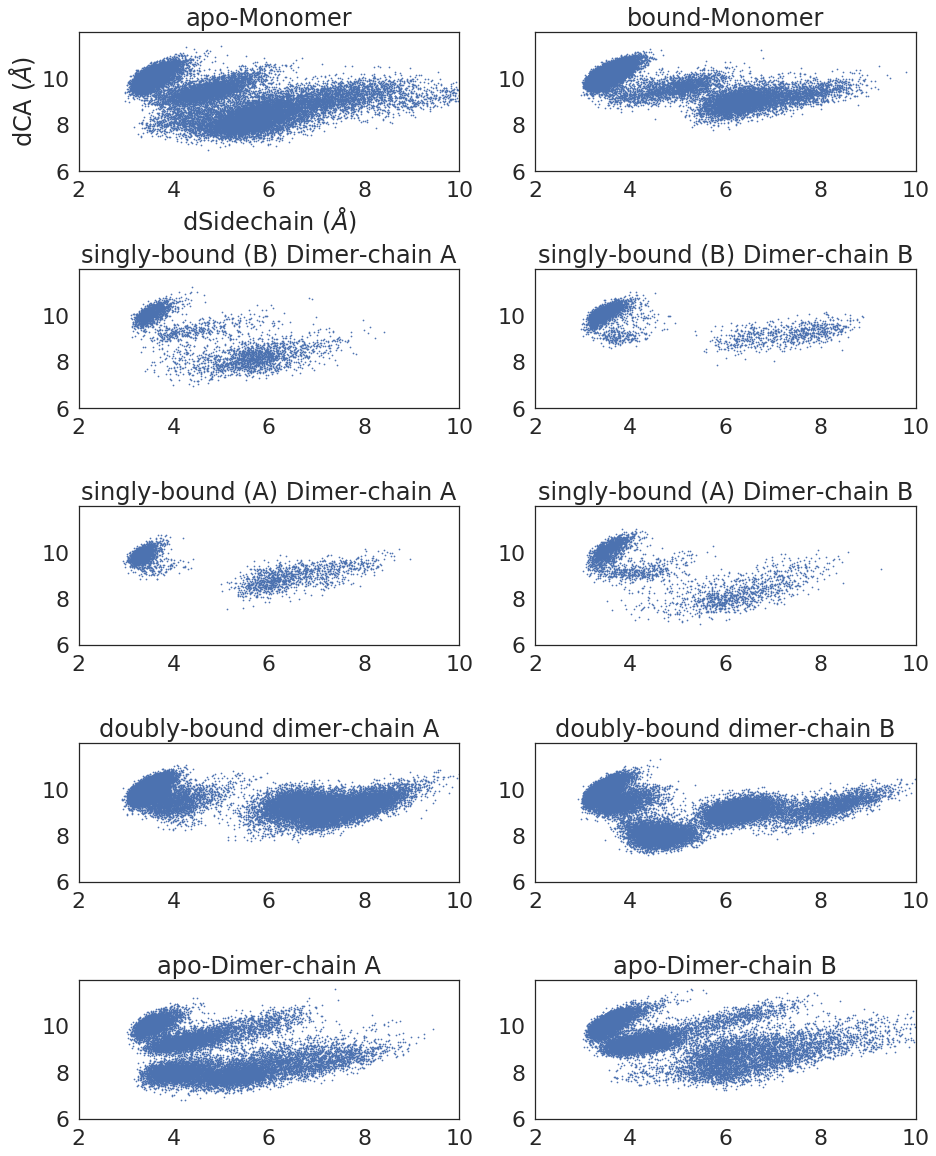

In [7]:
# sidechain dist vs CA dist

sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(state_names)//2 -1 ,2,figsize=(15,20))
model_data = np.zeros((1,2))
full_data = np.zeros((1,2))
fig.subplots_adjust(hspace=0.7,wspace=0.2)
for state in enumerate(data.keys()):
    if 'quad' in state[1]: continue
    dside = np.array([])
    dCA = np.array([])
    for run in data[state[1]].keys():
        #if run != 4: 
            #continue
        dside = np.append(dside,data[state[1]][run]['dside'])
        dCA = np.append(dCA,data[state[1]][run]['dCA'])
        full_data = np.r_[full_data,np.c_[dside,dCA]]
        if state[1] == 'dimer_sub2B': 
            model_data = np.r_[model_data,np.c_[dside,dCA]]
        #break
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    ax[xind][yind].scatter(dside,dCA,s=0.5)
    ax[xind][yind].set_ylim(6,12)
    ax[xind][yind].set_xlim(2,10)
    ax[xind][yind].set_xticks([2,4,6,8,10])
    ax[xind][yind].set_yticks([6,8,10])
    ax[xind][yind].set_title(state_names[state[1]])
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("dSidechain ($\AA$)")
        ax[xind][yind].set_ylabel("dCA ($\AA$)")

In [8]:
# generate and test GMM

train_len = 10000
n_train = 10
test_len = 70000
n_clusters = 5

print(len(model_data))
test_stat = np.zeros((n_train,n_clusters))

model_data_copy = np.copy(model_data[1:])
np.random.shuffle(model_data_copy)

for trial in range(0,n_train):
    start = train_len*trial
    end   = train_len*trial + train_len
    gmm = mixture.GaussianMixture(n_components=n_clusters, max_iter=2000,\
                                              covariance_type='full',tol=1e-8).fit(model_data_copy[start:end])
    #print(gmm.means_[:,0])
    model_labels = gmm.predict(model_data_copy[start:end])
    test_labels  = gmm.predict(model_data_copy[n_train*train_len:n_train*train_len+test_len])
    n,bins,patches = plt.hist(test_labels , density = True,bins=range(0,n_clusters+1),width=0.5)
    sort_inds = gmm.means_[:,0].argsort()
    plt.close()
    test_stat[trial] = n[sort_inds]

pred_labels = gmm.predict(full_data[1:])
model_labels = gmm.predict(model_data[1:])

254926


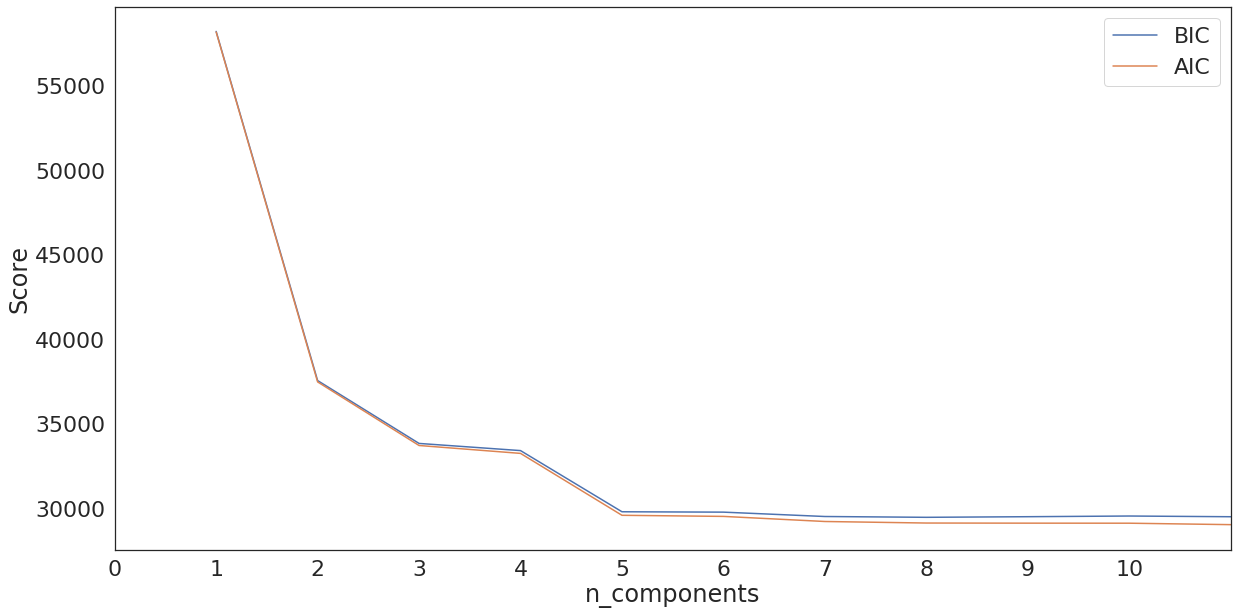

In [35]:
# BIC/AIC test
n_components = np.arange(1, 21)
n_model = 10000
sns.set(font_scale = 2)
sns.set_style('white')
fig = plt.figure(figsize = (20,10))
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0,max_iter=2000,tol=1e-5)\
          .fit(model_data_copy[1:n_model])
          for n in n_components]

plt.plot(n_components, [m.bic(model_data_copy[1:n_model]) for m in models], label='BIC')
plt.plot(n_components, [m.aic(model_data_copy[1:n_model]) for m in models], label='AIC')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.xlim(0,11)
plt.legend(loc='best')
plt.xlabel('n_components');
plt.ylabel('Score');

<BarContainer object of 5 artists>

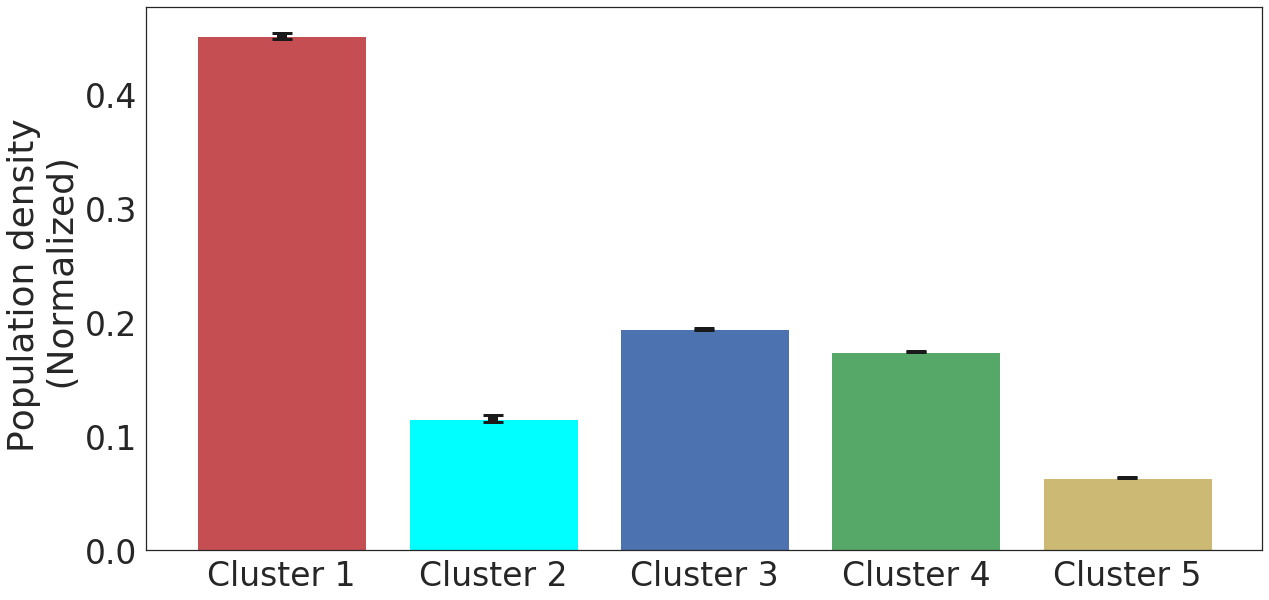

In [11]:
# test data prdictions and errors

Xlabels = []
test_stds = test_stat.std(axis=0)
test_means = test_stat.mean(axis=0)
#colors_sorted = [x for _,x in sorted(zip(gmm.means_[:,0],colors[:n_clusters]))]
colors_sorted = ['r','cyan','b','g','y']
sns.set(font_scale = 3)
sns.set_style('white')

fig,ax = plt.subplots(figsize=(20,10))

for i in range(0,n_clusters):
    Xlabels.append('Cluster ' + str(i+1))
    
error_kw=dict(lw=10, capsize=10, capthick=3)
ax.set_ylabel('Population density \n (Normalized)')
ax.bar(Xlabels, test_means, color = colors_sorted, yerr = test_stds, error_kw = error_kw)

Text(0, 0.5, 'dCA ($\\AA$)')

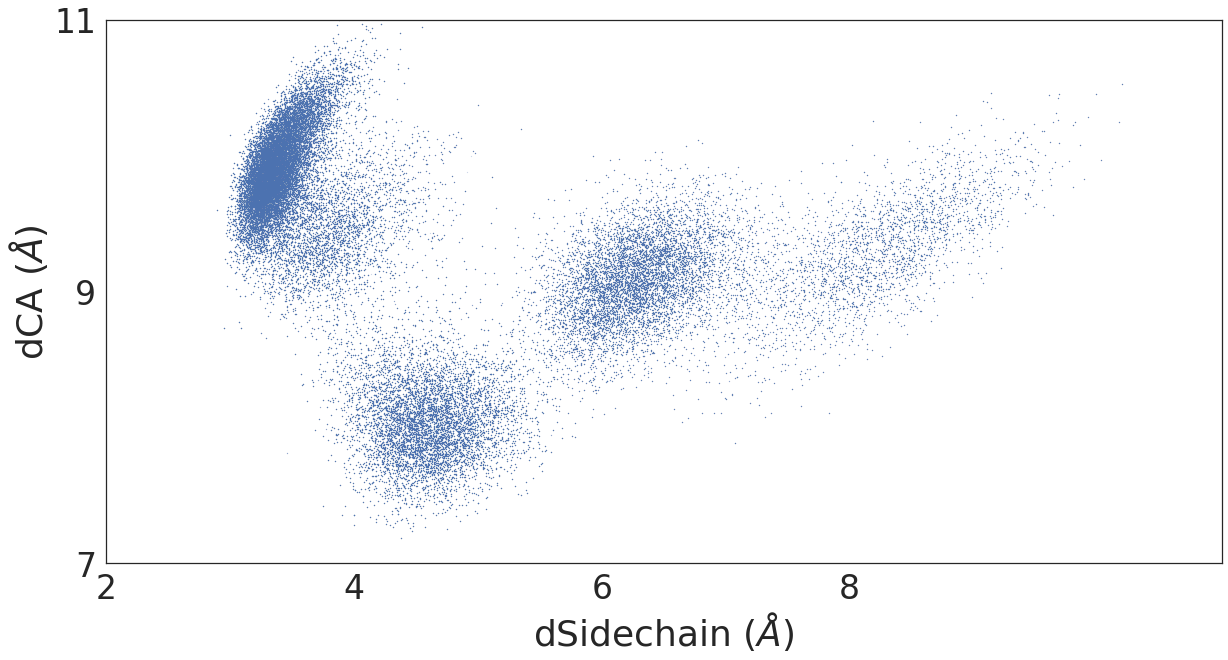

In [12]:
# unlabelled scatter
sns.set(font_scale = 3)
sns.set_style('white')
fig = plt.figure(figsize = (20,10))
plt.scatter(model_data[1:,0],model_data[1:,1],s=0.01)
plt.xlim(2,11)
plt.ylim(7,11)
plt.xticks([2,4,6,8])
plt.yticks([7,9,11])
plt.xlabel("dSidechain ($\AA$)")
plt.ylabel("dCA ($\AA$)")

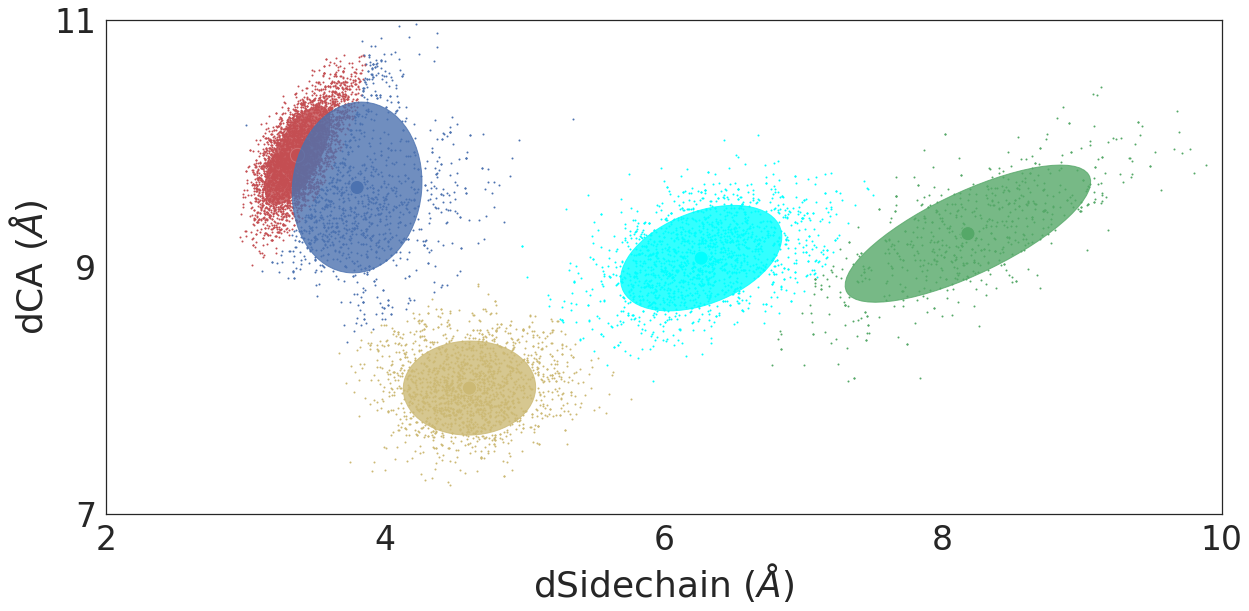

In [18]:
# GMM clustering of the model data

xlim = [3,10]
ylim = [7, 11]

labels = ["dSidechain ($\AA$)", "dCA ($\AA$)" ]
X=model_data_copy[1:train_len]
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_,1,xlim=xlim,ylim=ylim,labels=labels,\
             colors = colors_sorted)

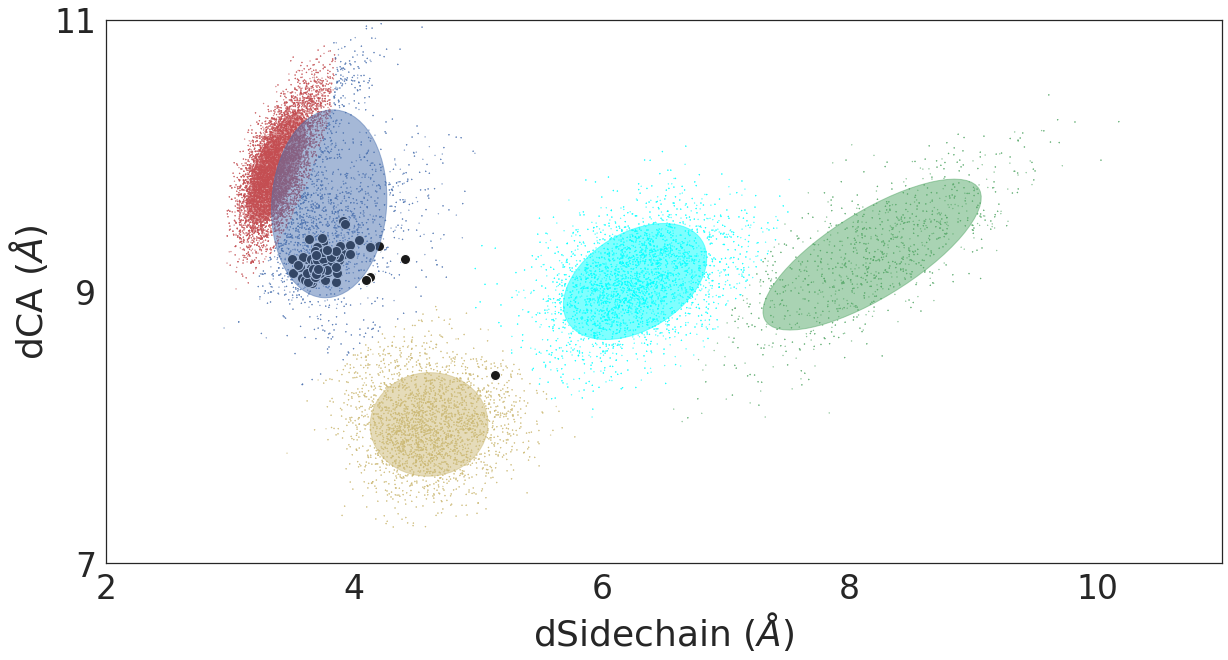

In [14]:
# plot CRYSTAL PDBs with ligand on GMM scatter

dsidePDB = {}
dCAPDB = {}
pdb_full = np.zeros((1,2))

fig,ax = plt.subplots(figsize=(20,10))
sns.set(font_scale = 3)
sns.set_style('white')

ax.scatter(model_data[1::10,0],model_data[1::10,1],s=0.1,c=np.array(colors_sorted)[model_labels[::10]])
for i, (mean, covar, color) in enumerate(zip(
            gmm.means_, gmm.covariances_, colors_sorted)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color,alpha=0.5)
        ell.set_clip_box(ax.bbox)
        #ell.set_alpha(0.8)
        ax.add_artist(ell)
        #ax.scatter(gmm.means_[:,0],gmm.means_[:,1],c=colors_sorted,s=200,edgecolor = 'white')

for pdbID in pdbs['ID']:
    print("Currently on ID: ", pdbID, end = '\r')
    model = md.Universe(pdb_path + pdbID + ".pdb")
    r42G = model.select_atoms("resid 41 and name CE1 and segid A")
    r146G = model.select_atoms("resid 145 and name SG and segid A")

    r42C = model.select_atoms("resid 41 and name CA and segid A")
    r146C = model.select_atoms("resid 145 and name CA and segid A")
    
    dsidePDB[pdbID] = scp.spatial.distance.euclidean(r42G.positions,r146G.positions)
    dCAPDB[pdbID] = scp.spatial.distance.euclidean(r42C.positions,r146C.positions)
    pdb_full = np.r_[pdb_full,np.c_[dsidePDB[pdbID],dCAPDB[pdbID]]]
    ax.scatter(dsidePDB[pdbID],dCAPDB[pdbID],s=100,c = 'k',edgecolors='white')

ax.set_xlim(2,11)
ax.set_ylim(7,11)
ax.set_xlabel("dSidechain ($\AA$)")
ax.set_ylabel("dCA ($\AA$)")

ax.set_xticks([2,4,6,8,10])
ax.set_yticks([7,9,11])  


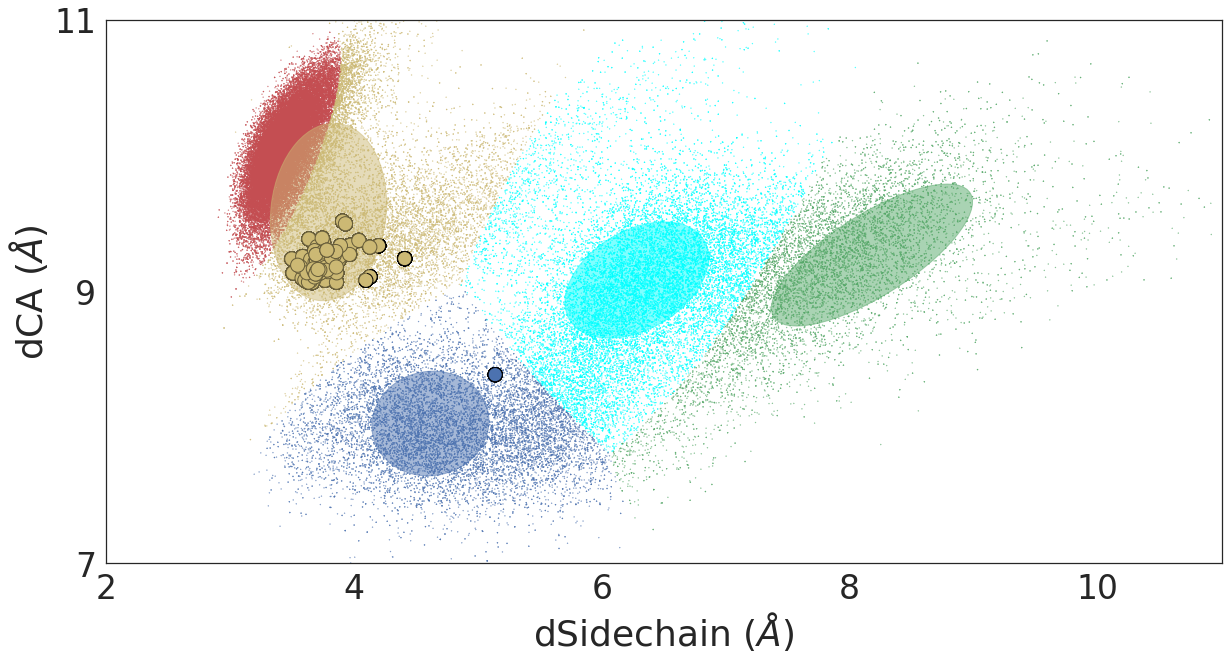

In [45]:
# plot CRYSTAL PDBs with ligand on GMM scatter

dsidePDB = {}
dCAPDB = {}
pdb_full = np.zeros((1,2))
sns.set(font_scale = 3)
sns.set_style('white')
fig,ax = plt.subplots(figsize=(20,10))


ax.scatter(full_data[1::10,0],full_data[1::10,1],s=0.1,c=np.array(colors_sorted)[pred_labels[::10]])
for i, (mean, covar, color) in enumerate(zip(
            gmm.means_, gmm.covariances_, colors_sorted)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color,alpha=0.5)
        ell.set_clip_box(ax.bbox)
        #ell.set_alpha(0.8)
        ax.add_artist(ell)
        #ax.scatter(gmm.means_[:,0],gmm.means_[:,1],c=colors_sorted,s=200,edgecolor = 'white')

for pdbID in pdbs['ID']:
    print("Currently on ID: ", pdbID, end = '\r')
    model = md.Universe(pdb_path + pdbID + ".pdb")
    r42G = model.select_atoms("resid 41 and name CE1 and segid A")
    r146G = model.select_atoms("resid 145 and name SG and segid A")

    r42C = model.select_atoms("resid 41 and name CA and segid A")
    r146C = model.select_atoms("resid 145 and name CA and segid A")
    
    dsidePDB[pdbID] = scp.spatial.distance.euclidean(r42G.positions,r146G.positions)
    dCAPDB[pdbID] = scp.spatial.distance.euclidean(r42C.positions,r146C.positions)
    pdb_full = np.r_[pdb_full,np.c_[dsidePDB[pdbID],dCAPDB[pdbID]]]
    #ax.scatter(dsidePDB[pdbID],dCAPDB[pdbID],s=100,c = 'k',edgecolors='white')
    
    pdb_labels = gmm.predict(pdb_full[1:]) 
    ax.scatter(pdb_full[1:,0],pdb_full[1:,1],s=200,c = np.array(colors_sorted)[pdb_labels], edgecolors = 'black')

ax.set_xlim(2,11)
ax.set_ylim(7,11)
ax.set_xlabel("dSidechain ($\AA$)")
ax.set_ylabel("dCA ($\AA$)")

ax.set_xticks([2,4,6,8,10])
ax.set_yticks([7,9,11])  


   


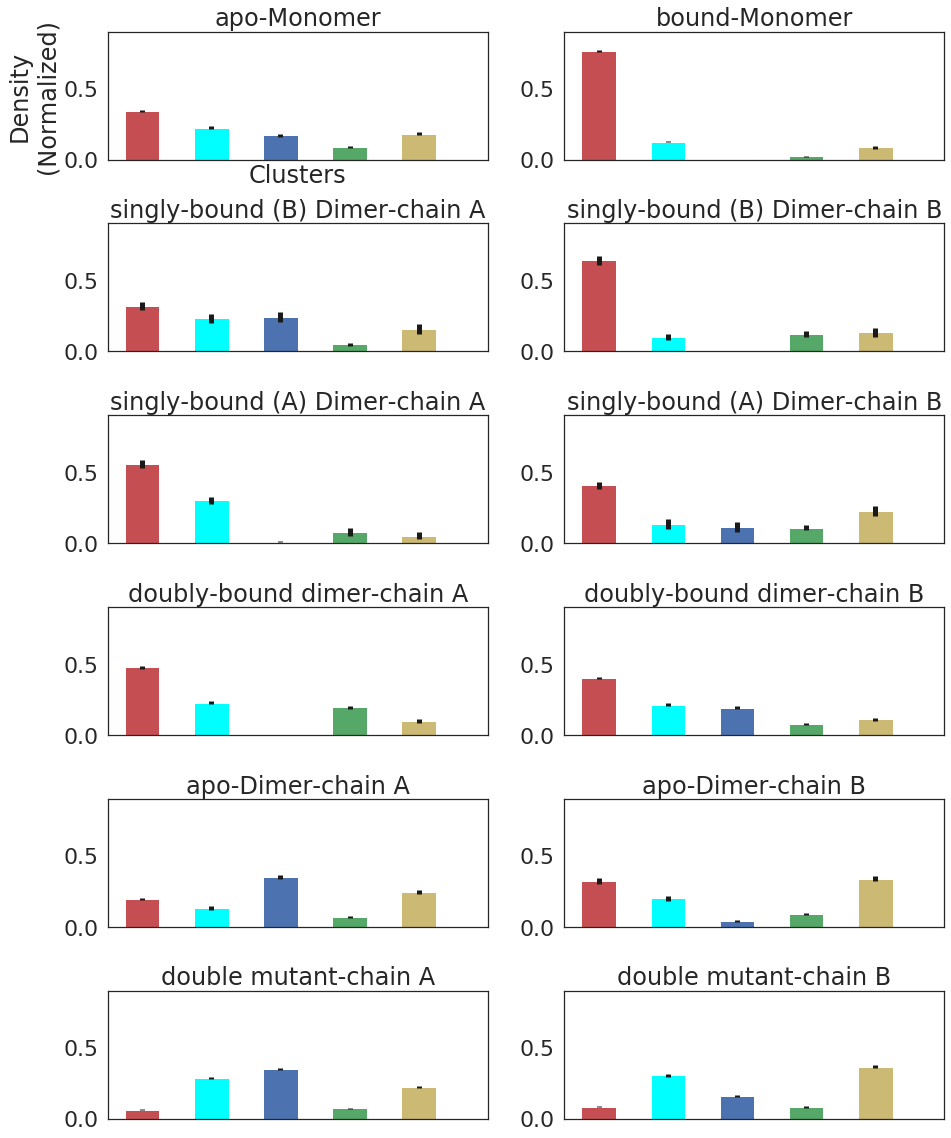

In [46]:
# histograms of the labels for the GMM for each state

traj_ratio= {}

sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(data)//2,2,figsize=(15,20))
#full_data = np.zeros((1,2))
fig.subplots_adjust(hspace=0.5,wspace=0.2)
for state in enumerate(data.keys()):
    #if 'quad' in state[1]:continue    
    traj_ratio[state[1]] = {}
    traj_ratio[state[1]]['stds'] = np.zeros(n_clusters)
    traj_ratio[state[1]]['avgs'] = np.zeros(n_clusters)
    dside = np.array([])
    dCA = np.array([])
    for run in data[state[1]].keys():
    
        dside = np.append(dside,data[state[1]][run]['dside'])
        dCA = np.append(dCA,data[state[1]][run]['dCA'])
    
    dside_copy = np.copy(dside)
    np.random.shuffle(dside_copy)
    dCA_copy = np.copy(dCA)
    np.random.shuffle(dCA_copy)
    
    
    #print(boot_len)
    n_sec=20
    boot_len = int(len(dside_copy)/n_sec)
    for boot in range(n_sec):

        state_labels = gmm.predict(np.c_[dside_copy[boot*boot_len:boot*boot_len+boot_len]\
                                         ,dCA_copy[boot*boot_len:boot*boot_len+boot_len]])
        
        n,bins = np.histogram(state_labels , density = True,bins=range(0,n_clusters+1))
        traj_ratio[state[1]]['stds'] += n**2 
        traj_ratio[state[1]]['avgs'] += n 
    
    traj_ratio[state[1]]['avgs'] = traj_ratio[state[1]]['avgs']/n_sec
    traj_ratio[state[1]]['stds'] = np.sqrt(traj_ratio[state[1]]['stds']/n_sec - traj_ratio[state[1]]['avgs']**2)
    
    
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    state_labels = gmm.predict(np.c_[dside,dCA])    
    n,bins,patches = ax[xind][yind].hist(state_labels , density = True,bins=range(0,n_clusters+1),width=0.5)
   
    x = bins[:-1]+0.25
    
    
    ax[xind][yind].set_ylim(0,0.9)
    #ax[state[0]].set_xlim(0,1)
    ax[xind][yind].set_xticks([])
    
    for patch in zip(colors_sorted[:n_clusters],patches):
        patch[1].set_facecolor(patch[0])
    #ax[xind][yind].set_yticks([7,9,11])
    ax[xind][yind].set_title(state_names[state[1]])
    if state[1] == 'monomer':
        ax[xind][yind].set_ylabel("Density\n(Normalized)")
        ax[xind][yind].set_xlabel("Clusters")
        
    ax[xind][yind].errorbar(x,n,yerr=traj_ratio[state[1]]['stds'],linestyle='None',linewidth=5,color='k')

74


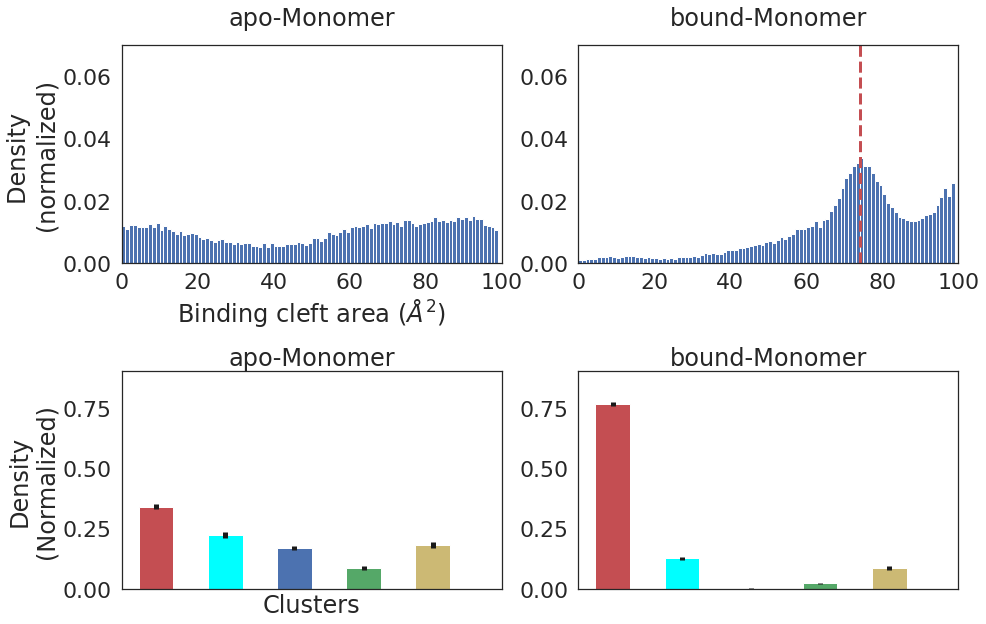

In [47]:
# monomer figures
sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(2 ,2 ,figsize=(15,10))
fig.subplots_adjust(hspace=0.5,wspace=0.2)
for state in enumerate(data.keys()):
    if 'monomer' not in state[1]: continue
    #print(state[1])
    side_hist = np.array([])
    for run in data[state[1]].keys():
    
        side_hist = np.append(side_hist,data[state[1]][run]['area'])
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    #print(state[0],xind,yind)
    
    ax[xind][yind].hist(np.array(side_hist),density = True,bins=range(0,100,1))
    
    
    n , edges = np.histogram(np.array(side_hist),density = True,bins=range(0,100,1))
    #print(np.argmax(n))
   
    if state[1] != 'monomer':
        #ax[0][yind].axvline(x=mon_mp, color = 'k', linewidth = 3, linestyle = '--')
        mon_mp = np.argmax(n)
        ax[0][yind].axvline(x=np.argmax(n), color = 'r', linewidth = 3, linestyle = '--')
        print(mon_mp)
    
    ax[xind][yind].set_xlim(0,100)
    ax[xind][yind].set_ylim(0,0.07)
    ax[xind][yind].set_title(state_names[state[1]],pad=20)
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("Binding cleft area ($\AA^2$)")
        ax[xind][yind].set_ylabel("Density \n(normalized)")

traj_ratio= {}
for state in enumerate(data.keys()):
    if 'monomer' not in state[1]:continue    
    traj_ratio[state[1]] = {}
    traj_ratio[state[1]]['stds'] = np.zeros(n_clusters)
    traj_ratio[state[1]]['avgs'] = np.zeros(n_clusters)
    dside = np.array([])
    dCA = np.array([])
    for run in data[state[1]].keys():
    
        dside = np.append(dside,data[state[1]][run]['dside'])
        dCA = np.append(dCA,data[state[1]][run]['dCA'])
    
    dside_copy = np.copy(dside)
    np.random.shuffle(dside_copy)
    dCA_copy = np.copy(dCA)
    np.random.shuffle(dCA_copy)
    
    
    #print(boot_len)
    n_sec=20
    boot_len = int(len(dside_copy)/n_sec)
    for boot in range(n_sec):

        state_labels = gmm.predict(np.c_[dside_copy[boot*boot_len:boot*boot_len+boot_len]\
                                         ,dCA_copy[boot*boot_len:boot*boot_len+boot_len]])
        
        n,bins = np.histogram(state_labels , density = True,bins=range(0,n_clusters+1))
        traj_ratio[state[1]]['stds'] += n**2 
        traj_ratio[state[1]]['avgs'] += n 
    
    traj_ratio[state[1]]['avgs'] = traj_ratio[state[1]]['avgs']/n_sec
    traj_ratio[state[1]]['stds'] = np.sqrt(traj_ratio[state[1]]['stds']/n_sec - traj_ratio[state[1]]['avgs']**2)
    
    
    xind = int(state[0]/2) + 1 # second row onwards
    yind = int(state[0]%2)
    state_labels = gmm.predict(np.c_[dside,dCA])    
    n,bins,patches = ax[xind][yind].hist(state_labels , density = True,bins=range(0,n_clusters+1),width=0.5)
   
    x = bins[:-1]+0.25
    
    
    ax[1][yind].set_ylim(0,0.9)
    #ax[state[0]].set_xlim(0,1)
    ax[1][yind].set_xticks([])
    
    for patch in zip(colors_sorted[:n_clusters],patches):
        patch[1].set_facecolor(patch[0])
    #ax[xind][yind].set_yticks([7,9,11])
    ax[1][yind].set_title(state_names[state[1]])
    if state[1] == 'monomer':
        ax[1][yind].set_ylabel("Density\n(Normalized)")
        ax[1][yind].set_xlabel("Clusters")
        
    ax[1][yind].errorbar(x,n,yerr=traj_ratio[state[1]]['stds'],linestyle='None',linewidth=5,color='k')

dimer_sub1AA
2 0 0
dimer_sub1AB
3 0 1
dimer_sub1AA
-1 0
dimer_sub1AB
-1 1


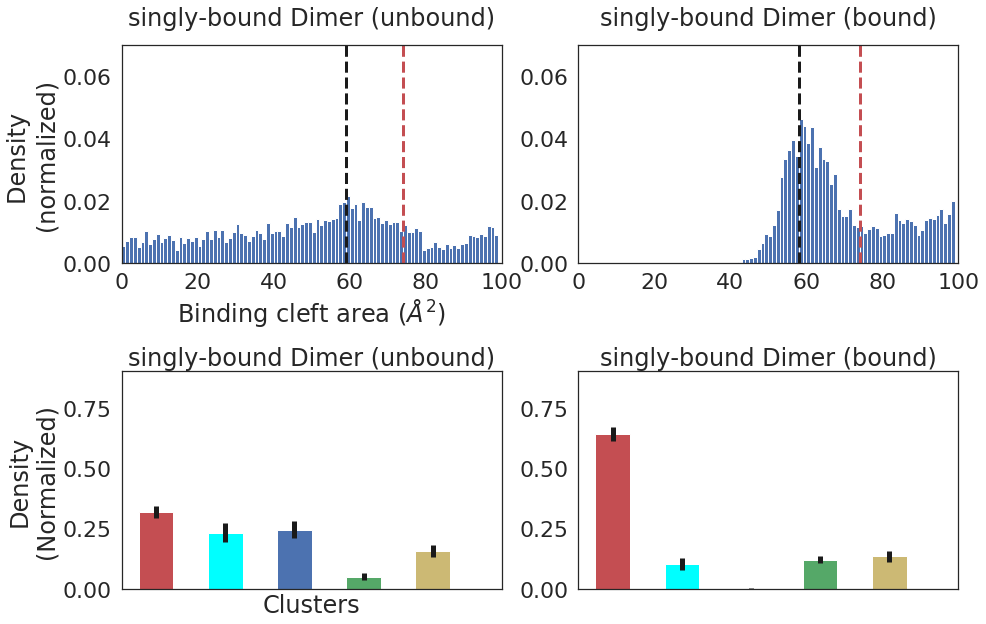

In [48]:
# singly bound dimer figures
sns.set(font_scale = 2)
sns.set_style('white')


dict_name = {'dimer_sub1AA':'singly-bound Dimer (unbound)','dimer_sub1AB':'singly-bound Dimer (bound)'}
fig,ax = plt.subplots(2 ,2 ,figsize=(15,10))
fig.subplots_adjust(hspace=0.5,wspace=0.2)
for state in enumerate(data.keys()):
    if 'dimer_sub1A' not in state[1]: continue
    print(state[1])
    side_hist = np.array([])
    for run in data[state[1]].keys():
    
        side_hist = np.append(side_hist,data[state[1]][run]['area'])
    xind = int(state[0]/2) -1
    yind = int(state[0]%2) 
    print(state[0],xind,yind)
    
    ax[xind][yind].hist(np.array(side_hist),density = True,bins=range(0,100,1))
    
    
    n , edges = np.histogram(np.array(side_hist),density = True,bins=range(0,100,1))
    #print(np.argmax(n))
   
    if state[1] == 'dimer_sub1AA':
        ax[xind][yind].axvline(x=np.argmax(n), color = 'k', linewidth = 3, linestyle = '--')
        ax[xind][yind].axvline(x=mon_mp, color = 'r', linewidth = 3, linestyle = '--')
        #mon_mp = np.argmax(n)
    else:
        ax[xind][yind].axvline(x=mon_mp, color = 'r', linewidth = 3, linestyle = '--')
        ax[xind][yind].axvline(x=np.argmax(n), color = 'k', linewidth = 3, linestyle = '--')
      
    
    ax[xind][yind].set_xlim(0,100)
    ax[xind][yind].set_ylim(0,0.07)
    ax[xind][yind].set_title(dict_name[state[1]],pad=20)
    if state[1] == 'dimer_sub1AA':
        ax[xind][yind].set_xlabel("Binding cleft area ($\AA^2$)")
        ax[xind][yind].set_ylabel("Density \n(normalized)")

traj_ratio= {}
for state in enumerate(data.keys()):
    if 'dimer_sub1A' not in state[1]:continue    
    print(state[1])
    traj_ratio[state[1]] = {}
    traj_ratio[state[1]]['stds'] = np.zeros(n_clusters)
    traj_ratio[state[1]]['avgs'] = np.zeros(n_clusters)
    dside = np.array([])
    dCA = np.array([])
    for run in data[state[1]].keys():
    
        dside = np.append(dside,data[state[1]][run]['dside'])
        dCA = np.append(dCA,data[state[1]][run]['dCA'])
    
    dside_copy = np.copy(dside)
    np.random.shuffle(dside_copy)
    dCA_copy = np.copy(dCA)
    np.random.shuffle(dCA_copy)
    
    #print(boot_len)
    n_sec=20
    boot_len = int(len(dside_copy)/n_sec)
    for boot in range(n_sec):

        state_labels = gmm.predict(np.c_[dside_copy[boot*boot_len:boot*boot_len+boot_len]\
                                         ,dCA_copy[boot*boot_len:boot*boot_len+boot_len]])
        
        n,bins = np.histogram(state_labels , density = True,bins=range(0,n_clusters+1))
        traj_ratio[state[1]]['stds'] += n**2 
        traj_ratio[state[1]]['avgs'] += n 
    
    traj_ratio[state[1]]['avgs'] = traj_ratio[state[1]]['avgs']/n_sec
    traj_ratio[state[1]]['stds'] = np.sqrt(traj_ratio[state[1]]['stds']/n_sec - traj_ratio[state[1]]['avgs']**2)
    
    
    xind = int(state[0]/2) - 2  # second row onwards
    yind = int(state[0]%2)
    print(xind,yind)
    state_labels = gmm.predict(np.c_[dside,dCA])    
    n,bins,patches = ax[xind][yind].hist(state_labels , density = True,bins=range(0,n_clusters+1),width=0.5)
   
    x = bins[:-1]+0.25
    
    
    ax[xind][yind].set_ylim(0,0.9)
    #ax[state[0]].set_xlim(0,1)
    ax[xind][yind].set_xticks([])
    
    for patch in zip(colors_sorted[:n_clusters],patches):
        patch[1].set_facecolor(patch[0])
    #ax[xind][yind].set_yticks([7,9,11])
    ax[xind][yind].set_title(dict_name[state[1]])
    if state[1] == 'dimer_sub1AA':
        ax[xind][yind].set_ylabel("Density\n(Normalized)")
        ax[xind][yind].set_xlabel("Clusters")
        
    ax[xind][yind].errorbar(x,n,yerr=traj_ratio[state[1]]['stds'],linestyle='None',linewidth=5,color='k')

dimerA
8 0 0
dimerB
9 0 1


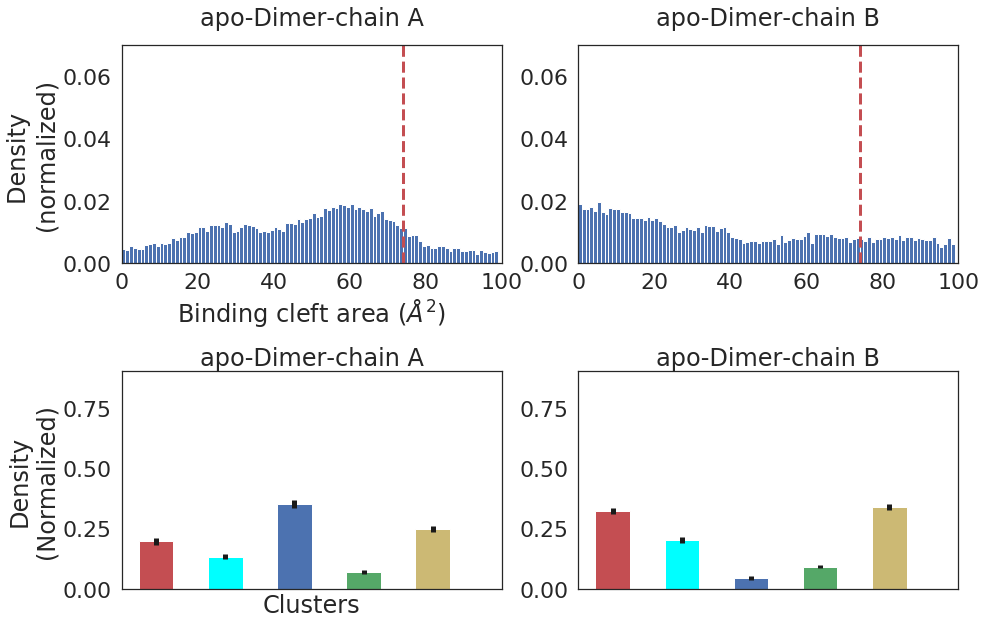

In [49]:
# apo dimer figures
sns.set(font_scale = 2)
sns.set_style('white')
fig,ax = plt.subplots(2 ,2 ,figsize=(15,10))
fig.subplots_adjust(hspace=0.5,wspace=0.2)
for state in enumerate(data.keys()):
    if 'dimer' not in state[1] or'sub' in state[1] or 'quad' in state[1]: continue
    print(state[1])
    side_hist = np.array([])
    for run in data[state[1]].keys():
    
        side_hist = np.append(side_hist,data[state[1]][run]['area'])
    xind = int(state[0]/2) -4
    yind = int(state[0]%2)
    print(state[0],xind,yind)
    
    ax[xind][yind].hist(np.array(side_hist),density = True,bins=range(0,100,1))
    
    
    n , edges = np.histogram(np.array(side_hist),density = True,bins=range(0,100,1))
    #print(np.argmax(n))
   
    if state[1] == 'dimerA':
        #ax[0][yind].axvline(x=np.argmax(n), color = 'k', linewidth = 3, linestyle = '--')
        ax[xind][yind].axvline(x=mon_mp, color = 'r', linewidth = 3, linestyle = '--')
        #mon_mp = np.argmax(n)
    else:
        ax[0][yind].axvline(x=mon_mp, color = 'r', linewidth = 3, linestyle = '--')
        #ax[0][yind].axvline(x=np.argmax(n), color = 'k', linewidth = 3, linestyle = '--')
      
    
    ax[xind][yind].set_xlim(0,100)
    ax[xind][yind].set_ylim(0,0.07)
    ax[xind][yind].set_title(state_names[state[1]],pad=20)
    if state[1] == 'dimerA':
        ax[xind][yind].set_xlabel("Binding cleft area ($\AA^2$)")
        ax[xind][yind].set_ylabel("Density \n(normalized)")

traj_ratio= {}
for state in enumerate(data.keys()):
    if 'dimer' not in state[1] or 'sub' in state[1] or 'quad'  in state[1]: continue    
    traj_ratio[state[1]] = {}
    traj_ratio[state[1]]['stds'] = np.zeros(n_clusters)
    traj_ratio[state[1]]['avgs'] = np.zeros(n_clusters)
    dside = np.array([])
    dCA = np.array([])
    for run in data[state[1]].keys():
    
        dside = np.append(dside,data[state[1]][run]['dside'])
        dCA = np.append(dCA,data[state[1]][run]['dCA'])
    
    dside_copy = np.copy(dside)
    np.random.shuffle(dside_copy)
    dCA_copy = np.copy(dCA)
    np.random.shuffle(dCA_copy)
    
    
    #print(boot_len)
    n_sec=20
    boot_len = int(len(dside_copy)/n_sec)
    for boot in range(n_sec):

        state_labels = gmm.predict(np.c_[dside_copy[boot*boot_len:boot*boot_len+boot_len]\
                                         ,dCA_copy[boot*boot_len:boot*boot_len+boot_len]])
        
        n,bins = np.histogram(state_labels , density = True,bins=range(0,n_clusters+1))
        traj_ratio[state[1]]['stds'] += n**2 
        traj_ratio[state[1]]['avgs'] += n 
    
    traj_ratio[state[1]]['avgs'] = traj_ratio[state[1]]['avgs']/n_sec
    traj_ratio[state[1]]['stds'] = np.sqrt(traj_ratio[state[1]]['stds']/n_sec - traj_ratio[state[1]]['avgs']**2)
    
    
    xind = int(state[0]/2) -3 # second row onwards
    yind = int(state[0]%2)
    state_labels = gmm.predict(np.c_[dside,dCA])    
    n,bins,patches = ax[xind][yind].hist(state_labels , density = True,bins=range(0,n_clusters+1),width=0.5)
   
    x = bins[:-1]+0.25
    
    
    ax[1][yind].set_ylim(0,0.9)
    #ax[state[0]].set_xlim(0,1)
    ax[1][yind].set_xticks([])
    
    for patch in zip(colors_sorted[:n_clusters],patches):
        patch[1].set_facecolor(patch[0])
    #ax[xind][yind].set_yticks([7,9,11])
    ax[1][yind].set_title(state_names[state[1]])
    if state[1] == 'dimerA':
        ax[1][yind].set_ylabel("Density\n(Normalized)")
        ax[1][yind].set_xlabel("Clusters")
        
    ax[1][yind].errorbar(x,n,yerr=traj_ratio[state[1]]['stds'],linestyle='None',linewidth=5,color='k')

dimer_sub2A
6 0 0
dimer_sub2B
7 0 1


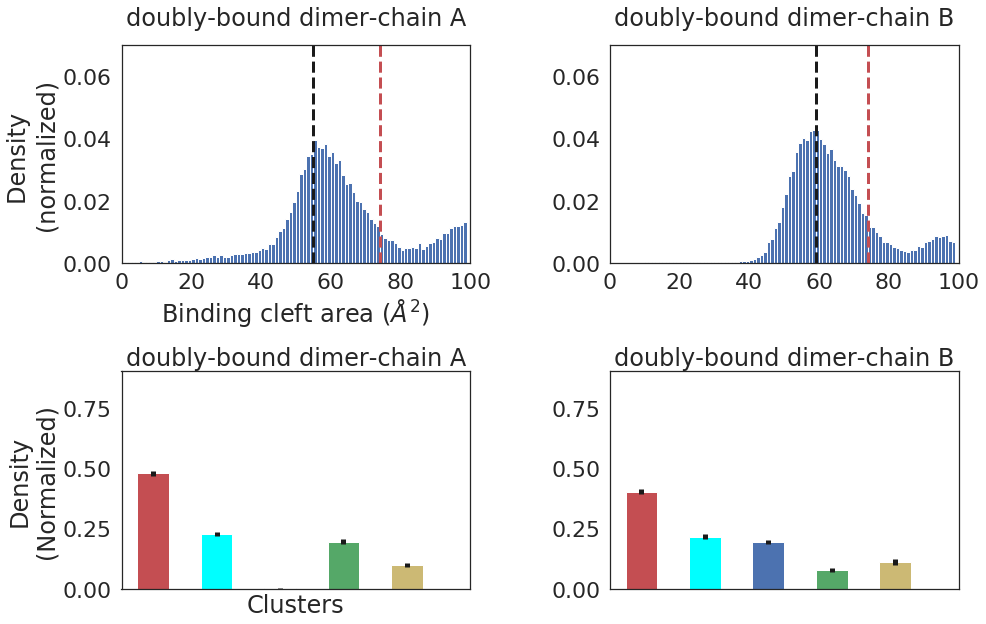

In [50]:
# doubly bound dimer figures
sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(2 ,2 ,figsize=(15,10))
fig.subplots_adjust(hspace=0.5,wspace=0.4)
for state in enumerate(data.keys()):
    if 'dimer' not in state[1] or 'sub2' not in state[1] or 'quad' in state[1]: continue
    print(state[1])
    side_hist = np.array([])
    for run in data[state[1]].keys():
    
        side_hist = np.append(side_hist,data[state[1]][run]['area'])
    xind = int(state[0]/2) -3
    yind = int(state[0]%2)
    print(state[0],xind,yind)
    
    ax[xind][yind].hist(np.array(side_hist),density = True,bins=range(0,100,1))
    
    
    n , edges = np.histogram(np.array(side_hist),density = True,bins=range(0,100,1))
    #print(np.argmax(n))
   
    if state[1] == 'dimerA':
        ax[0][yind].axvline(x=np.argmax(n), color = 'r', linewidth = 3, linestyle = '--')
        #mon_mp = np.argmax(n)
    else:
        ax[0][yind].axvline(x=mon_mp, color = 'r', linewidth = 3, linestyle = '--')
        ax[0][yind].axvline(x=np.argmax(n), color = 'k', linewidth = 3, linestyle = '--')
      
    
    ax[xind][yind].set_xlim(0,100)
    ax[xind][yind].set_ylim(0,0.07)
    ax[xind][yind].set_title(state_names[state[1]],pad=20)
    if state[1] == 'dimer_sub2A':
        ax[xind][yind].set_xlabel("Binding cleft area ($\AA^2$)")
        ax[xind][yind].set_ylabel("Density \n(normalized)")

traj_ratio= {}
for state in enumerate(data.keys()):
    if 'dimer' not in state[1] or 'sub2' not in state[1] or 'quad'  in state[1]: continue    
    traj_ratio[state[1]] = {}
    traj_ratio[state[1]]['stds'] = np.zeros(n_clusters)
    traj_ratio[state[1]]['avgs'] = np.zeros(n_clusters)
    dside = np.array([])
    dCA = np.array([])
    for run in data[state[1]].keys():
    
        dside = np.append(dside,data[state[1]][run]['dside'])
        dCA = np.append(dCA,data[state[1]][run]['dCA'])
    
    dside_copy = np.copy(dside)
    np.random.shuffle(dside_copy)
    dCA_copy = np.copy(dCA)
    np.random.shuffle(dCA_copy)
    
    
    #print(boot_len)
    n_sec=20
    boot_len = int(len(dside_copy)/n_sec)
    for boot in range(n_sec):

        state_labels = gmm.predict(np.c_[dside_copy[boot*boot_len:boot*boot_len+boot_len]\
                                         ,dCA_copy[boot*boot_len:boot*boot_len+boot_len]])
        
        n,bins = np.histogram(state_labels , density = True,bins=range(0,n_clusters+1))
        traj_ratio[state[1]]['stds'] += n**2 
        traj_ratio[state[1]]['avgs'] += n 
    
    traj_ratio[state[1]]['avgs'] = traj_ratio[state[1]]['avgs']/n_sec
    traj_ratio[state[1]]['stds'] = np.sqrt(traj_ratio[state[1]]['stds']/n_sec - traj_ratio[state[1]]['avgs']**2)
    
    
    xind = int(state[0]/2) -2 # second row onwards
    yind = int(state[0]%2)
    state_labels = gmm.predict(np.c_[dside,dCA])    
    n,bins,patches = ax[xind][yind].hist(state_labels , density = True,bins=range(0,n_clusters+1),width=0.5)
   
    x = bins[:-1]+0.25
    
    
    ax[1][yind].set_ylim(0,0.9)
    #ax[state[0]].set_xlim(0,1)
    ax[1][yind].set_xticks([])
    
    for patch in zip(colors_sorted[:n_clusters],patches):
        patch[1].set_facecolor(patch[0])
    #ax[xind][yind].set_yticks([7,9,11])
    ax[1][yind].set_title(state_names[state[1]])
    if state[1] == 'dimer_sub2A':
        ax[1][yind].set_ylabel("Density\n(Normalized)")
        ax[1][yind].set_xlabel("Clusters")
        
    ax[1][yind].errorbar(x,n,yerr=traj_ratio[state[1]]['stds'],linestyle='None',linewidth=5,color='k')

dimer_quad_mutantA
10 0 0
dimer_quad_mutantB
11 0 1


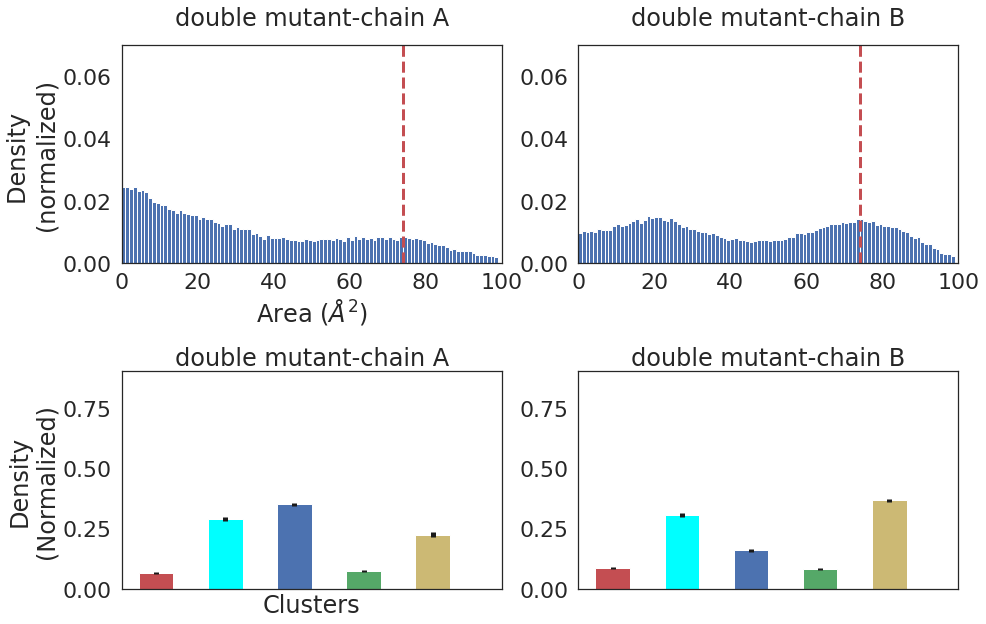

In [51]:
# doubly bound dimer figures
sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(2 ,2 ,figsize=(15,10))
fig.subplots_adjust(hspace=0.5,wspace=0.2)
for state in enumerate(data.keys()):
    if 'dimer' not in state[1] or 'quad' not in state[1]: continue
    print(state[1])
    side_hist = np.array([])
    for run in data[state[1]].keys():
    
        side_hist = np.append(side_hist,data[state[1]][run]['area'])
    xind = int(state[0]/2) -5
    yind = int(state[0]%2)
    print(state[0],xind,yind)
    
    ax[xind][yind].hist(np.array(side_hist),density = True,bins=range(0,100,1))
    
    
    n , edges = np.histogram(np.array(side_hist),density = True,bins=range(0,100,1))
    #print(np.argmax(n))
   
    if state[1] == 'dimerA':
        ax[0][yind].axvline(x=np.argmax(n), color = 'r', linewidth = 3, linestyle = '--')
        #mon_mp = np.argmax(n)
    else:
        ax[0][yind].axvline(x=mon_mp, color = 'r', linewidth = 3, linestyle = '--')
        #ax[0][yind].axvline(x=np.argmax(n), color = 'k', linewidth = 3, linestyle = '--')
      
    
    ax[xind][yind].set_xlim(0,100)
    ax[xind][yind].set_ylim(0,0.07)
    ax[xind][yind].set_title(state_names[state[1]],pad=20)
    if 'mutantA' in state[1] :
        ax[xind][yind].set_xlabel("Area ($\AA^2$)")
        ax[xind][yind].set_ylabel("Density \n(normalized)")

traj_ratio= {}
for state in enumerate(data.keys()):
    if 'dimer' not in state[1]  or not 'quad'  in state[1]: continue    
    traj_ratio[state[1]] = {}
    traj_ratio[state[1]]['stds'] = np.zeros(n_clusters)
    traj_ratio[state[1]]['avgs'] = np.zeros(n_clusters)
    dside = np.array([])
    dCA = np.array([])
    for run in data[state[1]].keys():
    
        dside = np.append(dside,data[state[1]][run]['dside'])
        dCA = np.append(dCA,data[state[1]][run]['dCA'])
    
    dside_copy = np.copy(dside)
    np.random.shuffle(dside_copy)
    dCA_copy = np.copy(dCA)
    np.random.shuffle(dCA_copy)
    
    
    #print(boot_len)
    n_sec=20
    boot_len = int(len(dside_copy)/n_sec)
    for boot in range(n_sec):

        state_labels = gmm.predict(np.c_[dside_copy[boot*boot_len:boot*boot_len+boot_len]\
                                         ,dCA_copy[boot*boot_len:boot*boot_len+boot_len]])
        
        n,bins = np.histogram(state_labels , density = True,bins=range(0,n_clusters+1))
        traj_ratio[state[1]]['stds'] += n**2 
        traj_ratio[state[1]]['avgs'] += n 
    
    traj_ratio[state[1]]['avgs'] = traj_ratio[state[1]]['avgs']/n_sec
    traj_ratio[state[1]]['stds'] = np.sqrt(traj_ratio[state[1]]['stds']/n_sec - traj_ratio[state[1]]['avgs']**2)
    
    
    xind = int(state[0]/2) -4 # second row onwards
    yind = int(state[0]%2)
    state_labels = gmm.predict(np.c_[dside,dCA])    
    n,bins,patches = ax[xind][yind].hist(state_labels , density = True,bins=range(0,n_clusters+1),width=0.5)
   
    x = bins[:-1]+0.25
    
    
    ax[1][yind].set_ylim(0,0.9)
    #ax[state[0]].set_xlim(0,1)
    ax[1][yind].set_xticks([])
    
    for patch in zip(colors_sorted[:n_clusters],patches):
        patch[1].set_facecolor(patch[0])
    #ax[xind][yind].set_yticks([7,9,11])
    ax[1][yind].set_title(state_names[state[1]])
    if 'mutantA' in state[1] :
        ax[1][yind].set_ylabel("Density\n(Normalized)")
        ax[1][yind].set_xlabel("Clusters")
        
    ax[1][yind].errorbar(x,n,yerr=traj_ratio[state[1]]['stds'],linestyle='None',linewidth=5,color='k')

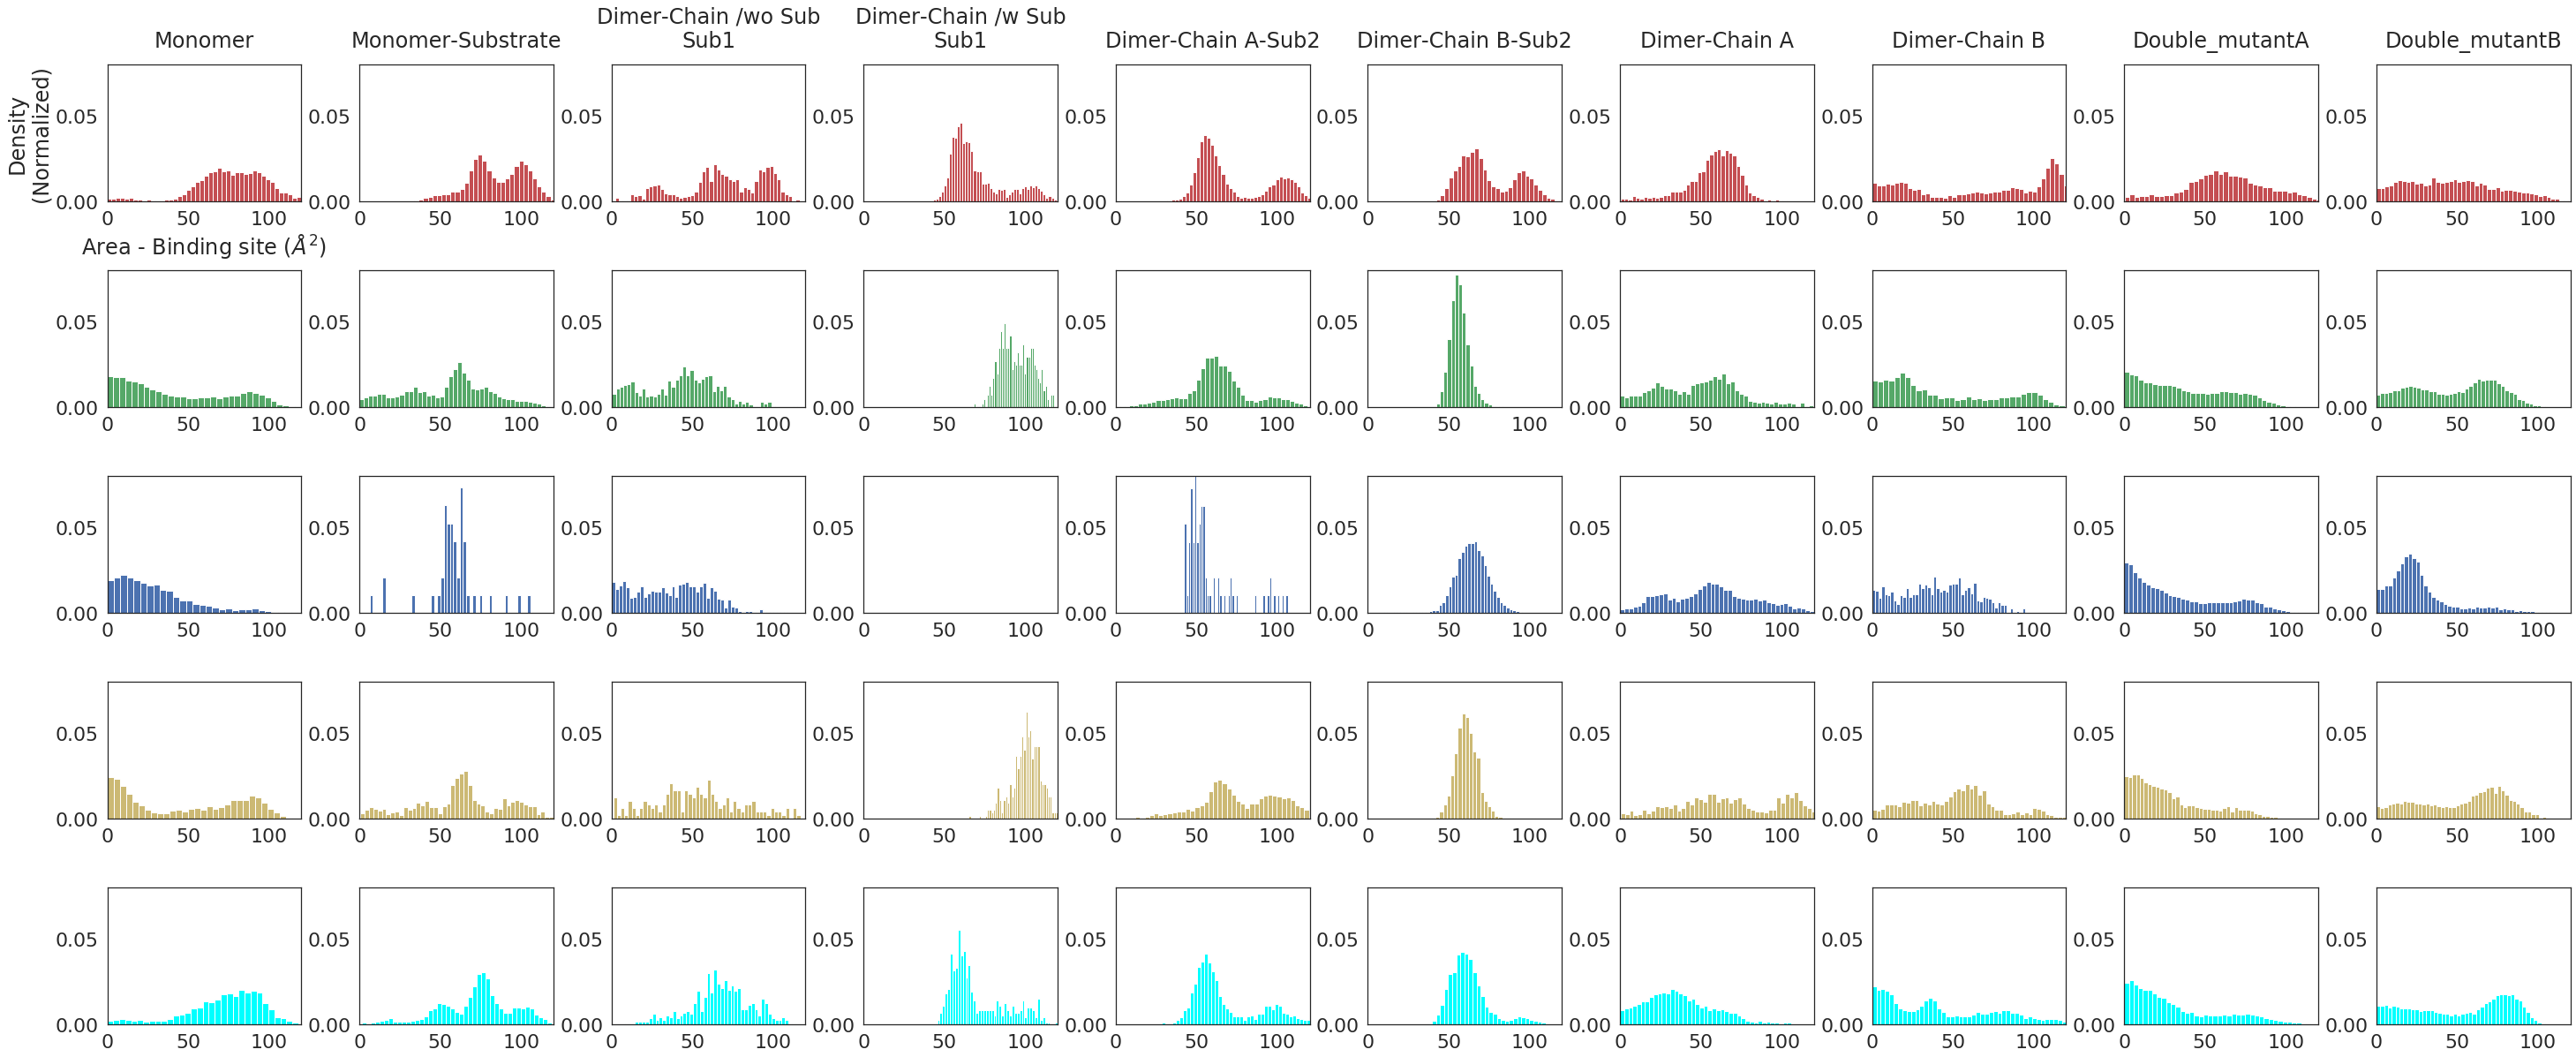

In [19]:
# histograms of the binding surface area for each cluster in each state
sns.set(font_scale = 2)
sns.set_style('white')
fig,ax = plt.subplots(n_clusters,n_states - 2,figsize=(50,20))
fig.subplots_adjust(hspace=0.5,wspace=0.3)
st_count = 0
for state in data.keys():
    #if 'quad' in state: continue
    if 'dimer_sub1B' in state: continue
    area = np.array([])
    dCA = np.array([])
    dside = np.array([])
    #if state[1][:-1] == 'dimer_sub':break
    for run in data[state].keys():
        if run>9 : break
        area = np.append(area,data[state][run]['area'])
        dside = np.append(dside,data[state][run]['dside'])
        dCA = np.append(dCA,data[state][run]['dCA'])
    state_labels = gmm.predict(np.c_[dside,dCA])
    for label in range(0,n_clusters):
        ax[label][st_count].hist(area[state_labels==label],density=1,color=colors[label],bins=50)
        if label == 0:
            
            if 'sub1AB' in state: 
                ax[label][st_count].set_title("Dimer-Chain /w Sub\nSub1",pad=20)
            elif 'sub1AA' in state: 
                ax[label][st_count].set_title("Dimer-Chain /wo Sub\nSub1",pad=20)  
            else:
                ax[label][st_count].set_title(state_names[state],pad=20)
                
        ax[label][st_count].set_ylim(0,0.08)
        ax[label][st_count].set_xlim(0,120)
        if state == 'monomer' and label == 0:
            ax[label][st_count].set_xlabel("Area - Binding site ($\AA^2$)")
            ax[label][st_count].set_ylabel("Density\n(Normalized)")
    st_count+=1

In [ ]:
# histograms of the binding surface area for each cluster in each state
sns.set(font_scale = 2)
sns.set_style('white')
fig,ax = plt.subplots(3,n_states - 4,figsize=(50,20))
fig.subplots_adjust(hspace=0.5,wspace=0.3)
st_count = 0
for state in data.keys():
    if 'quad' in state: continue
    if 'dimer_sub1B' in state: continue
    area = np.array([])
    bangle = np.array([])
    dinter1 = np.array([])
    dCA = np.array([])
    dside = np.array([])
    
    for run in data[state].keys():
        if run>9 : break
        area = np.append(area,data[state][run]['area'])
        bangle = np.append(bangle,data[state][run]['angle'])
        dinter1 = np.append(dinter1,data[state][run]['dinter1'])
        dside = np.append(dside,data[state][run]['dside'])
        dCA = np.append(dCA,data[state][run]['dCA'])
        
    state_labels = gmm.predict(np.c_[dside,dCA])
    label = 4
    
    for prop in enumerate([area,bangle,dinter1]):
        ax[prop[0]][st_count].hist(prop[1][state_labels==label],density=1,color=colors[label],bins=50)
        if prop[0] == 0:
            
            if 'sub1AB' in state: 
                ax[prop[0]][st_count].set_title("Dimer-Chain /w Sub\nSub1",pad=20)
            elif 'sub1AA' in state: 
                ax[prop[0]][st_count].set_title("Dimer-Chain /wo Sub\nSub1",pad=20)  
            else:
                ax[prop[0]][st_count].set_title(state_names[state],pad=20)
                
        #ax[prop[0]][st_count].set_ylim(0,0.08)
        #ax[prop[0]][st_count].set_xlim(0,120)
        
        if state == 'monomer' and label == 0:
            ax[prop[0]][st_count].set_xlabel("Area - Binding site ($\AA^2$)")
            ax[prop[0]][st_count].set_ylabel("Density\n(Normalized)")
    st_count+=1

In [ ]:
# projections
path = "/wrk/kaptan/projects/covid/analysis/pls/projections_dside/"

sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(state_names)//2,2,figsize=(15,40))
fig.subplots_adjust(hspace=0.5,wspace=0.2)
for state in enumerate(state_names.keys()):
    proj_data = np.array([])
    for run in range(0,10):
        
        proj_file = path + state[1] + "_" + str(run) + "_proj_area.xvg"
        if not os.path.exists(proj_file):continue
        proj = np.loadtxt(proj_file,comments=["@","&"])
        proj_data = np.append(proj_data,proj[:,1])
        #break
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    ax[xind][yind].hist(proj_data, bins = 40, density = True)
    ax[xind][yind].set_ylim(0,0.25)
    ax[xind][yind].set_xlim(-35,35)
    #ax[xind][yind].set_xticks([2,4,6,8,10])
    #ax[xind][yind].set_yticks([6,8,10])
    ax[xind][yind].set_title(state_names[state[1]])
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("Eigen ($\AA$)")
        ax[xind][yind].set_ylabel("Projection ($\AA$)")
    #break

/wrk/kaptan/opt/miniconda3/envs/py3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


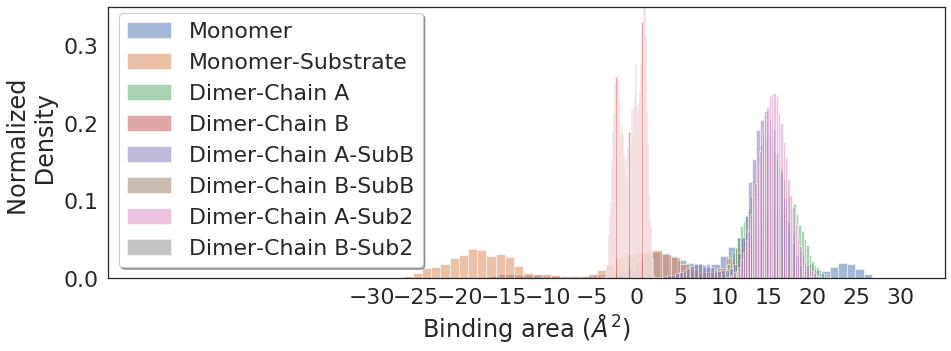

In [118]:
# projections area
path = "/wrk/kaptan/projects/covid/analysis/pls/projections_dside/"

sns.set(font_scale = 2)
sns.set_style('white')

fig = plt.figure(figsize=(15,5))
ax = fig.gca()
#fig.subplots_adjust(hspace=0.5,wspace=0.2)
for state in enumerate(['monomer','monomer_sub','dimerA','dimerB','dimer_sub1AA','dimer_sub1AB',\
                       'dimer_sub2A','dimer_sub2B']):
    proj_data = np.array([])
    for run in range(0,10):
        
        proj_file = path + state[1] + "_" + str(run) + "_proj_dside.xvg"
        if not os.path.exists(proj_file):continue
        proj = np.loadtxt(proj_file,comments=["@","&"])
        proj_data = np.append(proj_data,-proj[:,1])
        #break
    #xind = int(state[0]/2)
    #yind = int(state[0]%2)
    ax.hist(proj_data, bins = 50, density = True, alpha = 0.5, label = state_names[state[1]])
    ax.set_ylim(0,0.35)
    ax.set_xlim(-60,35)
    ax.set_xticks(range(-30,35,5))
    #ax.set_xticklabels(range(0,125,10))
    #ax[xind][yind].set_xticks([2,4,6,8,10])
    #ax[xind][yind].set_yticks([6,8,10])
    #ax.set_title(state_names[state[1]])
    if state[1] == 'monomer':
        ax.set_xlabel("Binding area ($\AA^2$)")
        ax.set_ylabel("Normalized \n Density")
    ax.legend(fancybox = 'True', shadow = 'True')
    #break

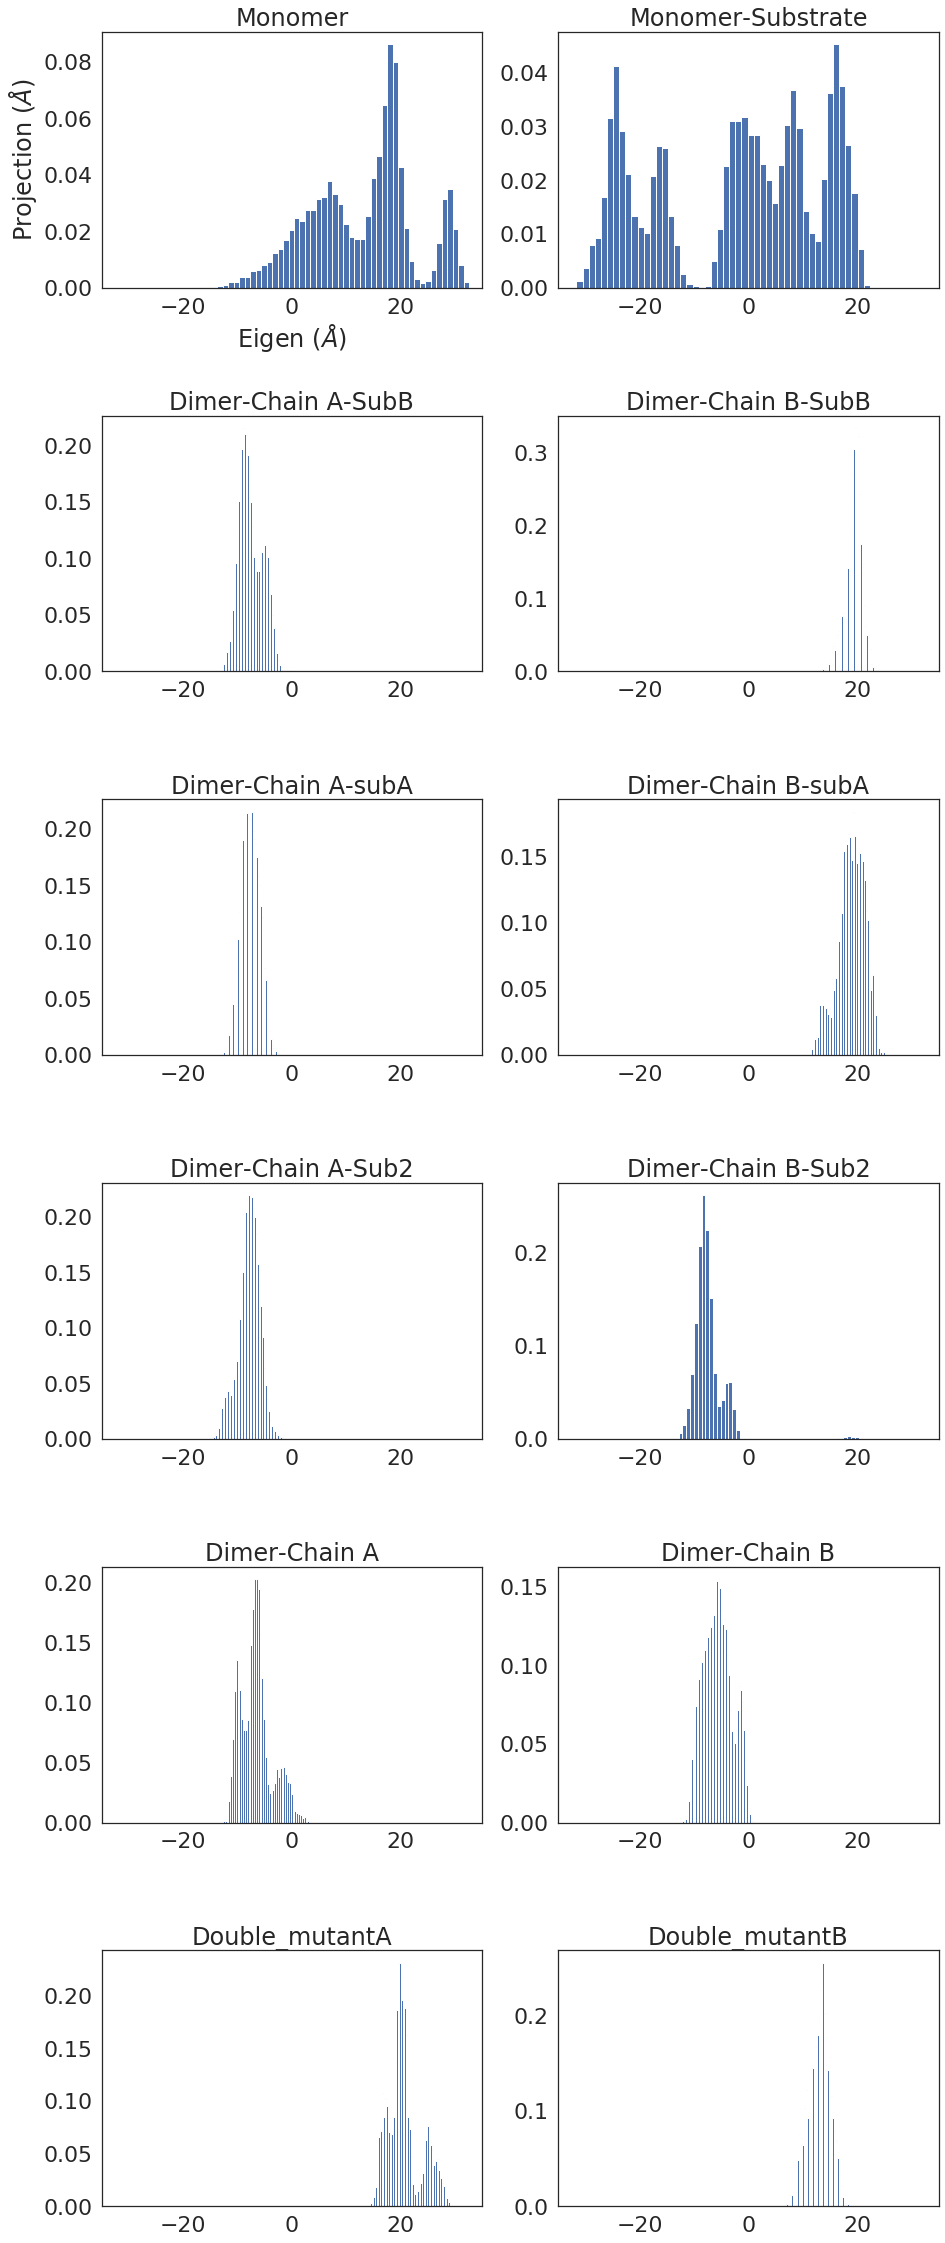

In [15]:
# projections
path = "/wrk/kaptan/projects/covid/analysis/pls/projections_dside/"

sns.set(font_scale = 2)
sns.set_style('white')

fig,ax = plt.subplots(len(state_names)//2,2,figsize=(15,40))
fig.subplots_adjust(hspace=0.5,wspace=0.2)
for state in enumerate(state_names.keys()):
    proj_data = np.array([])
    for run in range(0,10):
        
        proj_file = path + state[1] + "_" + str(run) + "_proj_area.xvg"
        if not os.path.exists(proj_file):continue
        proj = np.loadtxt(proj_file,comments=["@","&"])
        proj_data = np.append(proj_data,proj[:,1])
        #break
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    ax[xind][yind].hist(proj_data, bins = 50, density = True)
    #ax[xind][yind].set_ylim(0,0.25)
    ax[xind][yind].set_xlim(-35,35)
    #ax[xind][yind].set_xticks([2,4,6,8,10])
    #ax[xind][yind].set_yticks([6,8,10])
    ax[xind][yind].set_title(state_names[state[1]])
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("Eigen ($\AA$)")
        ax[xind][yind].set_ylabel("Projection ($\AA$)")
    #break

In [71]:
# analyzing the PLS vectors

pls_path = "/wrk/kaptan/projects/covid/analysis/pls/"
#dside_xtc = pls_path + "pls_filter_ew_dside.xtc"
area_xtc = pls_path + "pls_filter_ew.xtc"
pdb = pls_path + 'prot.pdb'

#model_dside = md.Universe(pdb,dside_xtc)
model_area = md.Universe(pdb,area_xtc)

for frame in model_area.trajectory:
    points = model_area.select_atoms("resid 190 143 50 25 167 and name CA")
    print(poly_area(points.positions))

OSError: File does not exist: b'/wrk/kaptan/projects/covid/analysis/pls/pls_filter_ew.xtc'

In [60]:
# contacts
data_path = '/wrk/kaptan/projects/covid/data/'
dimer = data_path + "/dimer_sub2/full.pdb"

model_dim = md.Universe(dimer)

chA = model_dim.select_atoms("segid A and name CA")
chB = model_dim.select_atoms("segid B and name CA")
chC = model_dim.select_atoms("segid C and name CA")
chD = model_dim.select_atoms("segid D and name CA")

contact_dist = scp.spatial.distance.cdist(chA.positions,chB.positions)
contact_values = contact_dist[contact_dist<10]
contact_map = contact_dist[contact_dist == contact_values]

contact_dist_sub = scp.spatial.distance.cdist(chA.positions,chC.positions)
contact_values_sub = contact_dist_sub[contact_dist_sub<10]
contact_map_sub = contact_dist_sub[contact_dist_sub == contact_values_sub]
contact_col = np.ones(len(chA)+2)*40
contact_col[1:307] = contact_dist_sub.min(axis=1)

/wrk/kaptan/opt/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/wrk/kaptan/opt/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [61]:
# residue concat
res_idnameA = []
res_idnameB = []
res_idnameC = []
res_idnameD = []
for res in chA.residues:
    res_idnameA.append(res.resname + str(res.resid))
    res_idnameB.append(res.resname + str(res.resid))
    
for res in chC.residues:
    res_idnameC.append(res.resname + str(res.resid))
    res_idnameD.append(res.resname + str(res.resid))

In [62]:
# rmsf analysis
path_rmsf = "/wrk/kaptan/projects/covid/analysis/rmsf/"
cha_nres = 308
chb_nres = 14
n_runs = 10 
rmsf_data = {}
#trim = [5:-10]

for state in ['monomer','monomer_sub','dimerA','dimerB','dimer_sub2A','dimer_sub2B','dimer_sub1AA','dimer_sub1AB',\
             'dimer_sub1BA','dimer_sub1BB']:

    rmsf_data[state] = {}
    
    rmsf_data[state]['prot'] = {}
    rmsf_data[state]['sub'] = {} 
    
    rmsf_data[state]['prot']['mean'] =  np.zeros(cha_nres)
    rmsf_data[state]['prot']['std'] =  np.zeros(cha_nres)
    rmsf_data[state]['sub']['mean'] =  np.zeros(chb_nres)
    rmsf_data[state]['sub']['std'] =  np.zeros(chb_nres)
    
    cur_path = path_rmsf + state + '/'
    
    act_run = 0
    for run in range(0,n_runs):

        cur_prot = cur_path + 'prot_rmsf_' + str(run)+'_'+ state + '.xvg'
        cur_sub = cur_path +   'sub_rmsf_' + str(run)+'_'+ state +'.xvg'
    
        
        if os.path.exists(cur_prot): 

            rmsf_data[state]['prot']['mean'] += np.loadtxt(cur_prot,comments=['&','@','#'])[:,1]
            rmsf_data[state]['prot']['std'] += np.loadtxt(cur_prot,comments=['&','@','#'])[:,1]**2
        
        if os.path.exists(cur_sub): 
      
            rmsf_data[state]['sub']['mean'] += np.loadtxt(cur_sub,comments=['&','@','#'])[:,1]
            rmsf_data[state]['sub']['std']   += np.loadtxt(cur_sub,comments=['&','@','#'])[:,1]**2
        act_run += 1
        
    rmsf_data[state]['prot']['mean']=rmsf_data[state]['prot']['mean']/act_run
    meansq = rmsf_data[state]['prot']['mean']**2
    exptsq = rmsf_data[state]['prot']['std']/act_run
    rmsf_data[state]['prot']['std']=np.sqrt(exptsq - meansq)
    
    if 'sub' in state:
        rmsf_data[state]['sub']['mean']=rmsf_data[state]['sub']['mean']/act_run
        meansq = rmsf_data[state]['sub']['mean']**2
        exptsq = rmsf_data[state]['sub']['std']/act_run
        rmsf_data[state]['sub']['std']=np.sqrt(exptsq - meansq)

    #plt.plot( rmsf_data[state]['prot']['mean'][5:-10])
    #plt.fill_between(x = range(cha_nres)[:-15], y1 = rmsf_data[state]['prot']['mean'][5:-10]-\
    #                 rmsf_data[state]['prot']['std'][5:-10]/2,\
    #                 y2 = rmsf_data[state]['prot']['mean'][5:-10]+rmsf_data[state]['prot']['std'][5:-10]/2 \
    #                 , alpha = 0.3 )
#plt.plot( rmsf_data['monomer']['prot']['mean'][5:-10] - rmsf_data['monomer_sub']['prot']['mean'][5:-10],\
#         linewidth=3)

#plt.plot( rmsf_data['monomer_sub']['sub']['mean'],\
#         linewidth=3)

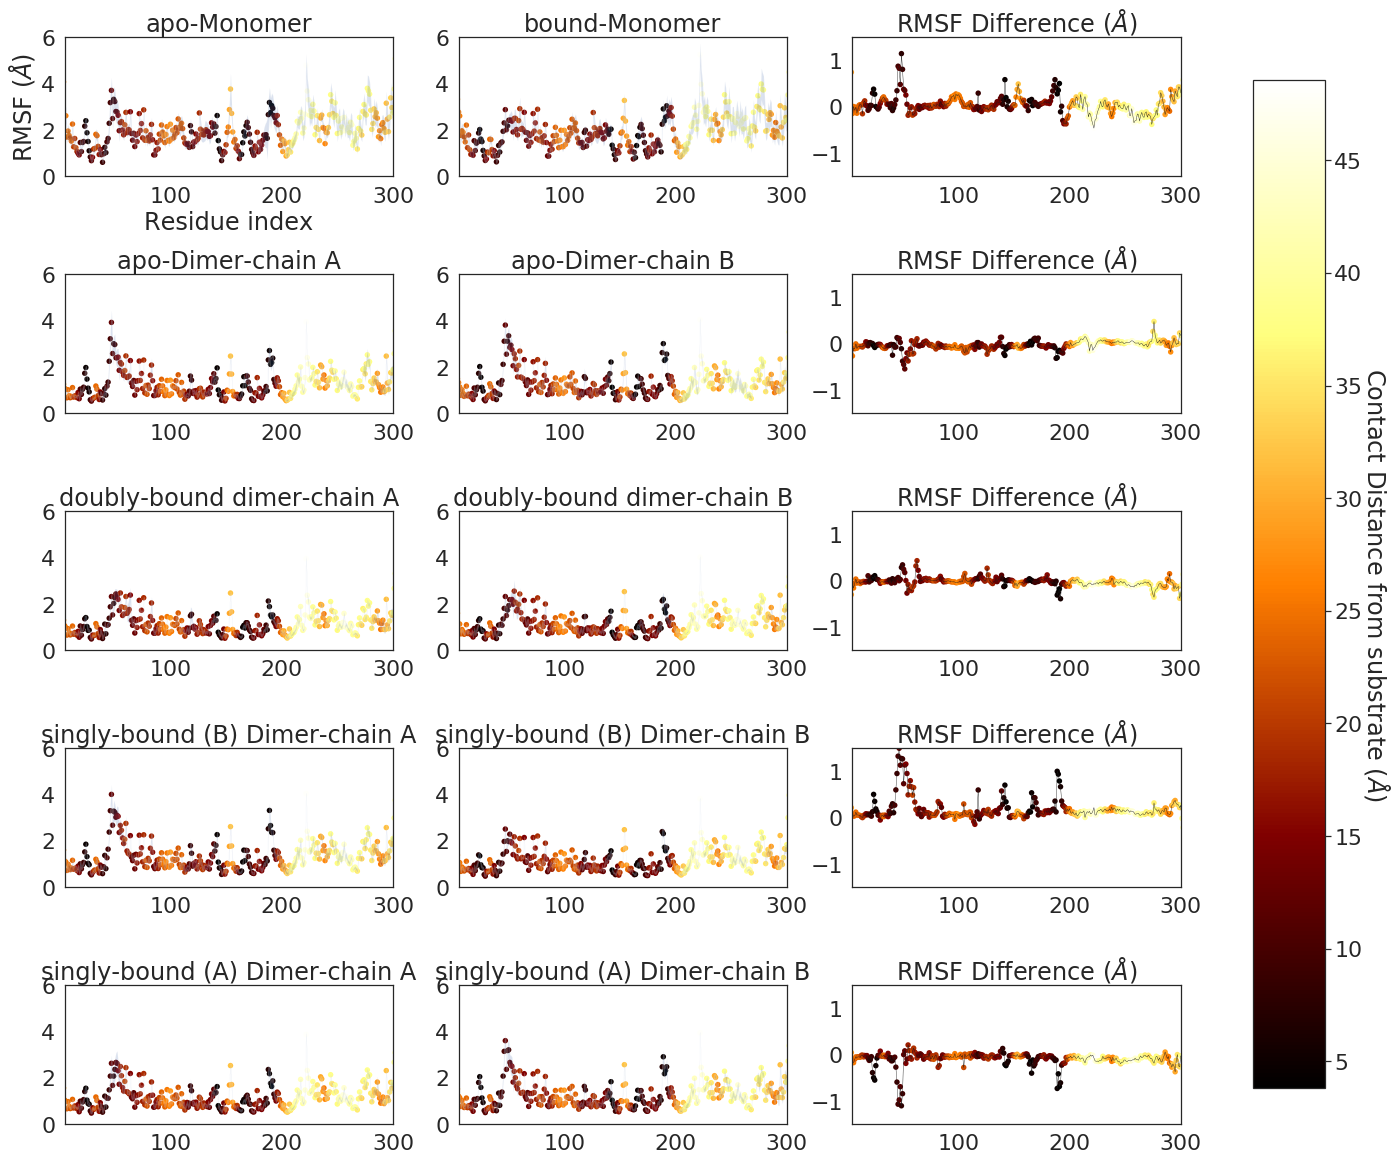

In [70]:
# RMSF diff
#path = "/wrk/kaptan/projects/covid/analysis/pls/projections_dside/"

sns.set(font_scale = 2)
sns.set_style('white')
keys = list(rmsf_data.keys())
fig,ax = plt.subplots(len(rmsf_data)//2,3,figsize=(20,20))
fig.subplots_adjust(hspace=0.7,wspace=0.2)

    


xaxis = range(0,308)

for state in enumerate(keys):
    xind = int(state[0]/2)
    yind = int(state[0]%2)
    if yind == 0:
        cur_key = keys[state[0]]
        prev_key = keys[state[0]+1]
       
        diff = rmsf_data[cur_key]['prot']['mean']*10 - rmsf_data[prev_key]['prot']['mean']*10
        ax[xind][2].plot(rmsf_data[cur_key]['prot']['mean']*10 - rmsf_data[prev_key]['prot']['mean']*10,\
                         linewidth = 0.4,\
                        color='k')
        
        scat = ax[xind][2].scatter(xaxis,diff,s=30,\
                           cmap=plt.cm.afmhot,c = contact_col,edgecolor='none')
        
        ax[xind][2].set_ylim(-1.5,1.5)
        ax[xind][2].set_xlim(5,300)
        ax[xind][2].set_title("RMSF Difference ($\AA$)" )
        
    ax[xind][yind].plot(rmsf_data[state[1]]['prot']['mean']*10,linewidth=0.01)
    ax[xind][yind].scatter(xaxis,rmsf_data[state[1]]['prot']['mean']*10,s=30,\
                           cmap=plt.cm.afmhot,c = contact_col,edgecolor='none')
    ax[xind][yind].fill_between(x = range(cha_nres), y1 = rmsf_data[state[1]]['prot']['mean']*10-\
                     rmsf_data[state[1]]['prot']['std']*10/2,\
                     y2 = rmsf_data[state[1]]['prot']['mean']*10+rmsf_data[state[1]]['prot']['std']*10/2 \
                     , alpha = 0.2 )
    
    ax[xind][yind].set_ylim(0,6)
    ax[xind][yind].set_xlim(5,300)
    #
    #ax[xind][yind].set_xticks([2,4,6,8,10])
    #ax[xind][yind].set_yticks([6,8,10])
    ax[xind][yind].set_title(state_names[state[1]])
    if state[1] == 'monomer':
        ax[xind][yind].set_xlabel("Residue index")
        ax[xind][yind].set_ylabel("RMSF ($\AA$)")
    #break
    
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(scat,cax=cbar_ax)
cbar.set_label("Contact Distance from substrate $(\AA)$", rotation=270,labelpad=30)

In [55]:
# area along the PLS mode

pls_path = "/wrk/kaptan/projects/covid/analysis/pls/"
pdb = pls_path + 'prot.pdb'
xtc = pls_path + 'dside_ew.xtc'

pls_model = md.Universe(pdb,xtc)
points = pls_model.select_atoms("resid 190 143 50 25 167 and name CA")
three_points = pls_model.select_atoms("resid 94 128 279 and name CA")

chainB = "/wrk/kaptan/projects/covid/data/monomer/chainB.pdb"
modelB = md.Universe(chainB)

r291B = modelB.select_atoms("resid 291 and name CD")
r5B = modelB.select_atoms("resid 5 and name CZ")
        
r291A = pls_model.select_atoms("resid 291 and name CD")
r5A = pls_model.select_atoms("resid 5 and name CZ")

r42G = pls_model.select_atoms("resid 42 and name CE1")
r146G = pls_model.select_atoms("resid 146 and name SG")

r42C = pls_model.select_atoms("resid 42 and name CA")
r146C = pls_model.select_atoms("resid 146 and name CA")

dAB = np.zeros(pls_model.trajectory.n_frames)
dBA = np.zeros(pls_model.trajectory.n_frames)
b_angle = np.zeros(pls_model.trajectory.n_frames)
pls_area = np.zeros(pls_model.trajectory.n_frames)
dca = np.zeros(pls_model.trajectory.n_frames)
dside = np.zeros(pls_model.trajectory.n_frames)

frame_count = 0
for frame in pls_model.trajectory:
    
    d1 = scp.spatial.distance.euclidean\
            (r5A.positions,r291B.positions)
            
    d2 = scp.spatial.distance.euclidean\
            (r291A.positions,r5B.positions)
    
    angle = tpangle(three_points.positions)
    
    pls_area[frame_count] = poly_area(points.positions)
    b_angle[frame_count] = angle
    dAB[frame_count] = d1 - 4
    dBA[frame_count] = d2 - 4 
    
    dca[frame_count] = scp.spatial.distance.euclidean\
            (r42C.positions,r146C.positions)
    
    dside[frame_count] = scp.spatial.distance.euclidean\
            (r42G.positions,r146G.positions)
    
    frame_count+=1

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


/wrk/kaptan/projects/covid/analysis/pls//projections_dside/dimerA_1_proj_dside.xvg
/wrk/kaptan/projects/covid/analysis/pls//projections_dside/dimerA_7_proj_dside.xvg
/wrk/kaptan/projects/covid/analysis/pls//projections_dside/dimerA_8_proj_dside.xvg
/wrk/kaptan/projects/covid/analysis/pls//projections_dside/dimerA_9_proj_dside.xvg


No handles with labels found to put in legend.
No handles with labels found to put in legend.


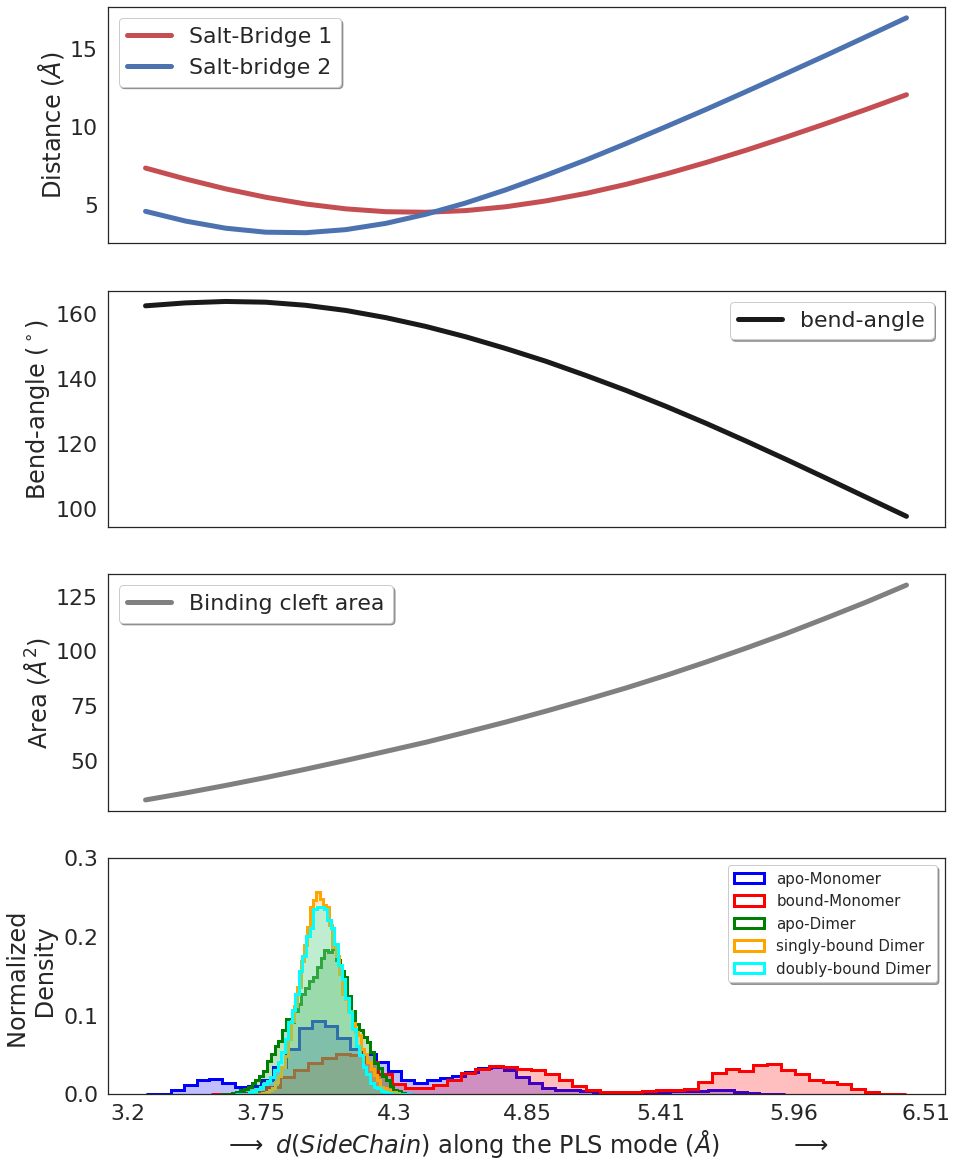

In [65]:
# pls_figures
sns.set(font_scale = 2)
sns.set_style('white')
pls_cols = ['blue','red','green','orange','cyan']
fig, ax = plt.subplots(4, figsize=(15,20))
changed_labels = {'monomer':'apo-Monomer','monomer_sub':'bound-Monomer','dimerA':'apo-Dimer'\
                  ,'dimer_sub1AB':'singly-bound Dimer','dimer_sub2A': 'doubly-bound Dimer'}
#fig.subplots_adjust(hspace=0.5,wspace=0.2)
for state in enumerate(['monomer','monomer_sub','dimerA','dimer_sub1AB','dimer_sub2A']):
    proj_data = np.array([])
    for run in range(0,10):
        
        proj_file = pls_path + "/projections_dside/" + state[1] + "_" + str(run) + "_proj_dside.xvg"
        if not os.path.exists(proj_file):
            print(proj_file)
            continue
        proj = np.loadtxt(proj_file,comments=["@","&"])
        proj_data = np.append(proj_data,proj[:,1])
        #break
    #print(proj_data)
    x_axis = np.round(np.linspace(dside.min(),dside.max(),8),2)
    ax[3].hist(proj_data, bins = 50, density = True,  label = changed_labels[state[1]],\
               color=pls_cols[state[0]],histtype='step',linewidth=3,)
    ax[3].hist(proj_data, bins = 50, density = True,\
               color=pls_cols[state[0]],histtype='stepfilled',linewidth=0.001, alpha=0.25)
    #ax[4].set_xticks(xaxis)
    ax[3].set_xticklabels(x_axis)
    
    ax[3].set_ylim(0,0.3)
    #ax[4].set_xlim(-30,30)
    ax[3].legend(fancybox = 'True', shadow = 'True',prop={'size': 15})
    
    """
    ax[4].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    """
    
    ax[1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    ax[2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    """
    ax[3].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    """
    #ax.set_xticks(range(-30,30,6))
    #ax.set_xticklabels(range(0,10,1))
    #ax[xind][yind].set_xticks([2,4,6,8,10])
    #ax[xind][yind].set_yticks([6,8,10])
    #ax.set_title(state_names[state[1]])
    if state[1] == 'monomer':
        ax[3].set_xlabel("$\longrightarrow$ $d(SideChain)$ along the PLS mode $(\AA)$ \
        $\longrightarrow$")
        ax[3].set_ylabel("Normalized \n Density")
    ax[1].legend(fancybox = 'True', shadow = 'True')

#ax[0].set_ylabel("Distance ($\AA$)")
#ax[0].plot(dside,linewidth=5, color = 'green', label = '$d(SideChain)$')
#ax[0].plot(dca,linewidth=5, color = 'orange', label = '$d(CA)$')
#ax[0].set_yticks([2,4,6,8,10])
#ax[0].legend(fancybox = 'True', shadow = 'True')

ax[0].plot(dAB,linewidth=5, color = 'r', label = 'Salt-Bridge 1')
ax[0].plot(dBA,linewidth=5, color = 'b', label = 'Salt-bridge 2')
ax[0].set_ylabel("Distance ($\AA$)")
ax[0].legend(fancybox = 'True', shadow = 'True')


ax[1].plot(b_angle,linewidth=5, color = 'k', label = 'bend-angle')
ax[1].set_ylabel("Bend-angle ($^\circ$)")
ax[1].legend(fancybox = 'True', shadow = 'True')

ax[2].plot(pls_area,linewidth=5, color = 'gray', label = 'Binding cleft area')
ax[2].set_ylabel("Area ($\AA^2$)")
ax[2].legend(fancybox = 'True', shadow = 'True',)
#break

In [ ]:
# plotting salt bridges of the closed structure 
fig_cm_first, ax_cm_first = plt.subplots(figsize=(5,60))
#ax_cm_first.set_xlim(0,len(neg_res_labels))
#ax_cm_first.set_ylim(0,len(pos_res_labels))

#fig_cm.tight_layout()


cb_first = ax_cm_first.pcolor(contact_dist_sub,edgecolor='k', cmap='Spectral',vmin=0\
                            ,vmax=20,label='Saltbridge distances ($\AA$)')
#ax_cm_first.set_aspect('equal')
ax_cm_first.set_xticks(plt.arange(1,len(res_idnameC)+1,1))
ax_cm_first.set_yticks(plt.arange(1,len(res_idnameA)+1,1))
ax_cm_first.set_xticklabels(res_idnameC,size=10,rotation=90)
ax_cm_first.set_yticklabels(res_idnameA,size=10)
ax_cm_first.set_xlabel('Anionic residues',size=60)
ax_cm_first.set_ylabel('Cationic residues',size=60)
#ax_cm.set_ylabel('MlaC residue IDs',size=60)
#ax_cm.set_title('Chain A-B from the minimum system',size=80,y=1.02)

cbar_cm_first = fig_cm_first.add_axes([1, 0.1, 0.03, 0.8])
cbar_cm_first.tick_params(labelsize=60) 

cmbar_cm_first = fig_cm_first.colorbar(cb_first,cax=cbar_cm_first)

In [ ]:
# plotting salt bridges of the closed structure 
fig_cm_first, ax_cm_first = plt.subplots(figsize=(60,60))
#ax_cm_first.set_xlim(0,len(neg_res_labels))
#ax_cm_first.set_ylim(0,len(pos_res_labels))

#fig_cm.tight_layout()


cb_first = ax_cm_first.pcolor(contact_dist,edgecolor='k', cmap='Spectral',vmin=0\
                            ,vmax=20,label='Saltbridge distances ($\AA$)')
ax_cm_first.set_aspect('equal')
ax_cm_first.set_xticks(plt.arange(1,len(res_idnameA)+1,1))
ax_cm_first.set_yticks(plt.arange(1,len(res_idnameB)+1,1))
ax_cm_first.set_xticklabels(res_idnameA,size=10,rotation=90)
ax_cm_first.set_yticklabels(res_idnameB,size=10)
ax_cm_first.set_xlabel('Anionic residues',size=60)
ax_cm_first.set_ylabel('Cationic residues',size=60)
#ax_cm.set_ylabel('MlaC residue IDs',size=60)
#ax_cm.set_title('Chain A-B from the minimum system',size=80,y=1.02)

cbar_cm_first = fig_cm_first.add_axes([1, 0.1, 0.03, 0.8])
cbar_cm_first.tick_params(labelsize=60) 

cmbar_cm_first = fig_cm_first.colorbar(cb_first,cax=cbar_cm_first)